# CPSC 330 Lecture 19

Outline:

- Announcements
- Supervised vs. Unsupervised Learning
- Clustering intro (10 min)
- $k$-means clustering (10 min)
- Choosing $k$ (10 min)
- Distances (10 min)
- Break (5 min)
- DBSCAN (10 min)
- Hierarchical clustering (10 min)
- True/False questions (15 min)

In [1]:
import numpy as np
import random

from sklearn import datasets
from scipy.spatial import distance
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.patches import Ellipse, Polygon

# plt.style.use("seaborn")

In [2]:
plt.rcParams['font.size'] = 16

Some extra functions for plotting, the code is included in this repo:

In [3]:
from support_functions import *

## Announcements

- How are people doing? https://piazza.com/class/kb2e6nwu3uj23?cid=545
- hw7 deadline passed, hw8 coming today
- Pre-watching videos for next time, if you can.
- Today's class:
  - Is a CPSC 340 style lecture based on tools rather than a dataset.
  - Will be review for you if you've taken 340.
  - Will try to get back to data when I can!

# Supervised vs Unsupervised Learning

- Most of what we do in this course is supervised learning: given $x$, try to predict $y$
- But the nearest neighbour item recommendations we did was unsupervised learning.
  - We did not have labels telling is the "correct answer" for our recommendations.
- This is the same thing here. It is also unsupervised learning.

#### Iris dataset

In [4]:
## Wine dataset
wine = datasets.load_wine()
data_wine = pd.DataFrame(wine.data, columns=wine.feature_names) 
data_wine['target'] = wine.target_names[wine.target]

## Iris dataset
iris = datasets.load_iris() # loading the iris dataset
features = iris.data # get the input data
labels = iris.target_names[iris.target] # get the responses, in this case the specie of the flowers

# Reducing the dimensionality for plotting purposes 
pca = PCA(n_components=2) 
pca.fit(features)
data_iris = pd.DataFrame(pca.transform(features), columns=['$Z_1$', '$Z_2$'])
data_iris['target'] = labels

/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w + h})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w + h})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w + h})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w + h})


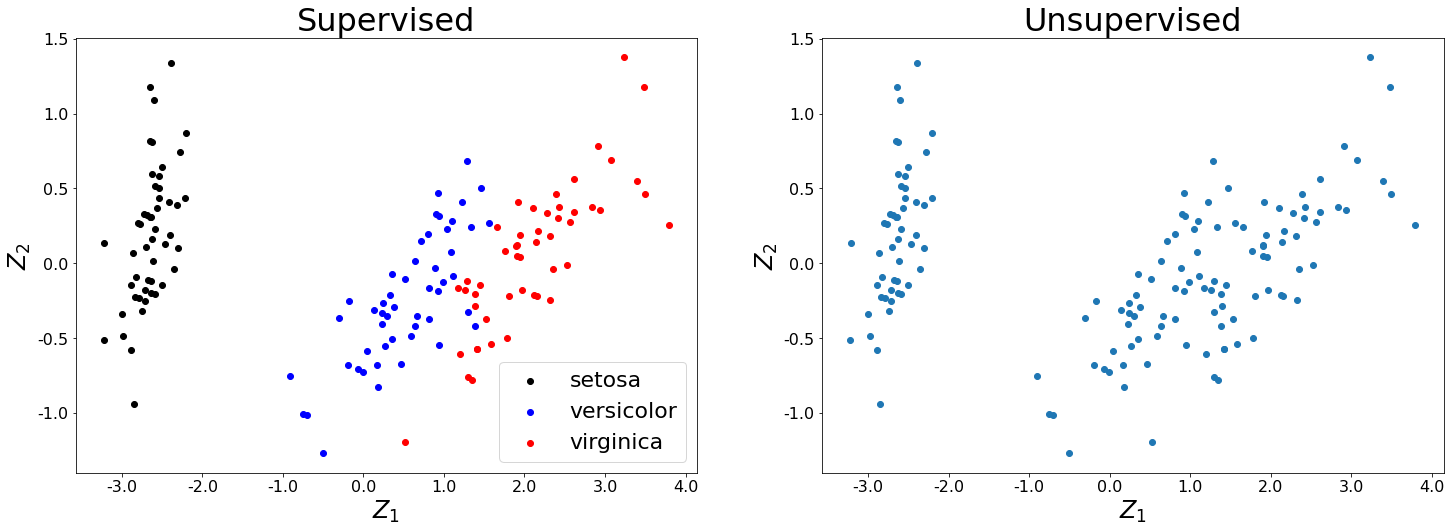

In [5]:
plot_sup_x_unsup(data_iris, 8, 8)

## Clustering intro (10 min)

- We want to group the observations in such a way that:
    1. Examples in the same group are as similar as possible;
    2. Examples in different groups are as different as possible.
    
A very interesting talk about an application of clustering: [Malcom Gladwell - Spaghetti Sauce](https://www.ted.com/talks/malcolm_gladwell_on_spaghetti_sauce?language=en).

- But what is similar?
- The idea of similarity can be really tricky, which makes it hard for us to objectively measure the quality of a clustering algorithm (or think about true clusters);    

**Question:** How would you group a deck of cards? 

- In a deck of cards:
    1. We have two colors: black and <font color="red">red</font>;
    2. We have four suits: Clubs, Spades, <font color="red">Hearts</font>, and <font color="red">Diamonds</font>;
    3. We have 13 values: $\left\{A,2,3,4,5,6,7,8,9,10,J,Q,K\right\}$.

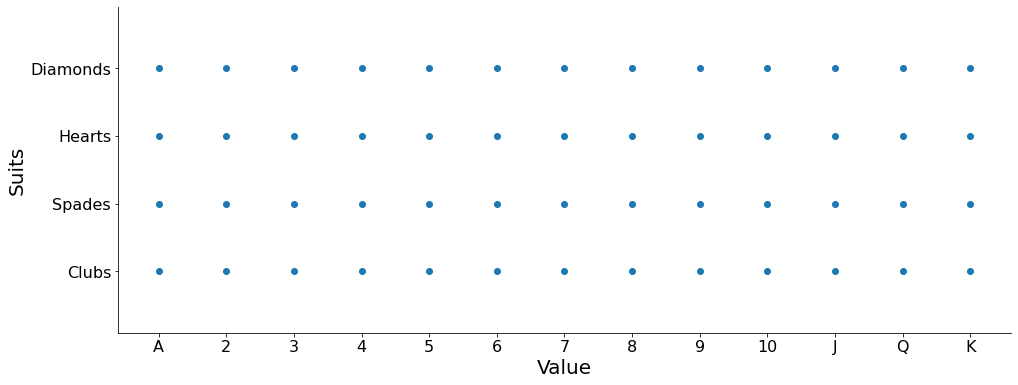

In [6]:
plot_deck(group_by='cards', w=16, h=6)

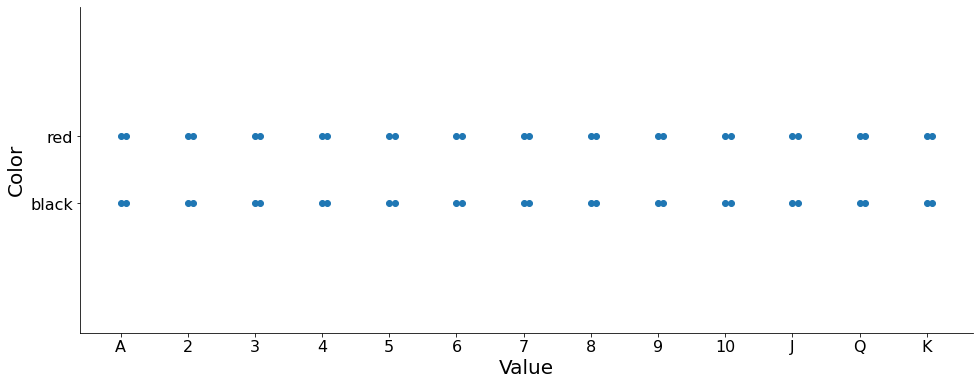

In [7]:
plot_deck(group_by='color', w=16, h=6)

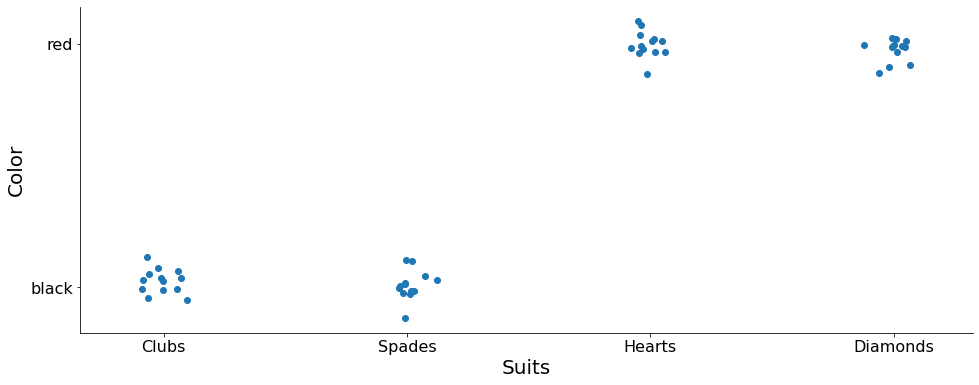

In [8]:
plot_deck(group_by='suits', w=16, h=6)

- What would be the true clusters here?
    1. Should we cluster by colors?
    2. Should we cluster by suits: Clubs, Spades, <font color="red">Hearts</font>, and <font color="red">Diamonds</font>?
    3. Should we cluster by value?
    4. Should we cluster by value and color (e.g, 2 of spades and 2 of clubs)?

- All these options seem reasonable - so what is the "right answer"?
- In clustering, meaningful groups are dependent on the application.

### Clustering vs classification

- Although close to the idea of classification, clustering is unsupervised, i.e., the labels are unknown.
- There is no point in thinking of "true" or "correct" cluster; the best we can do is to talk about optimal (in some sense) cluster.
- Generally, not even the number of clusters is known.
  - How many spaghetti sauce types should we make?

/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w})


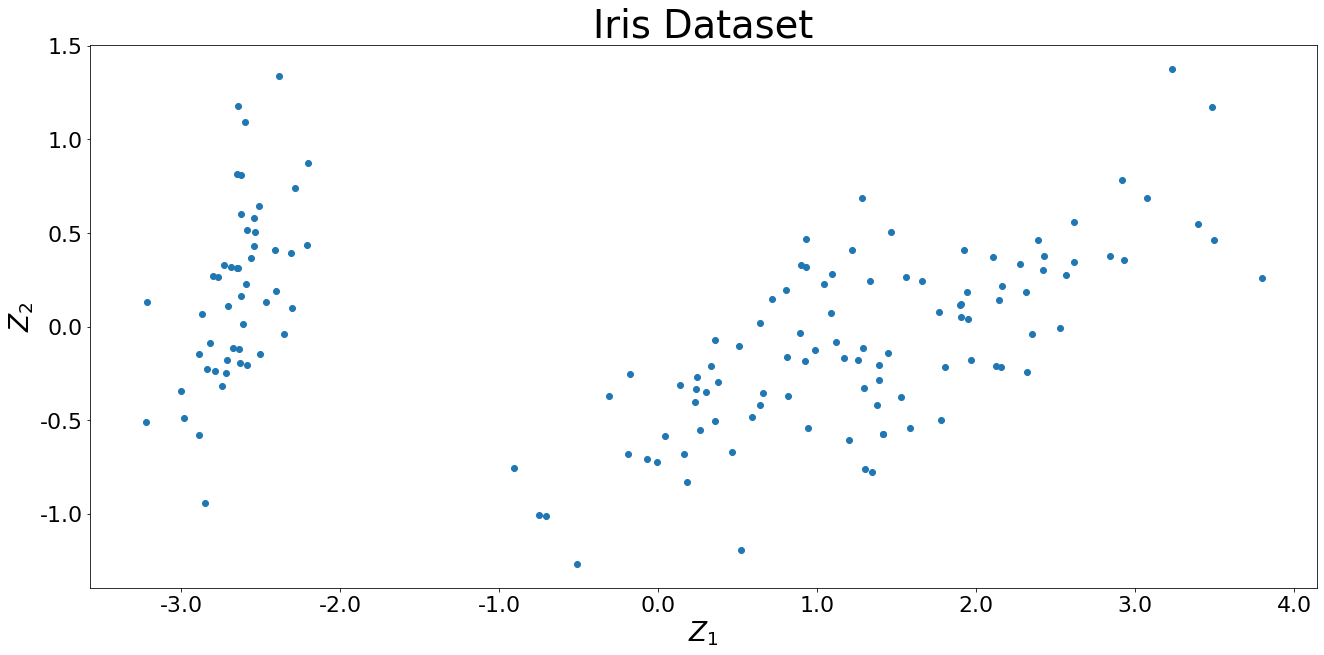

In [9]:
plot_unsup(data_iris, 22,10, "Iris Dataset")

## $k$-means clustering (10 min)

- We want find clusters (groups) of data points.
- Think of colouring the points (e.g., black, red, blue), such that points with the same colour are close to each other.
  - But remember that the colours themselves have no significance.

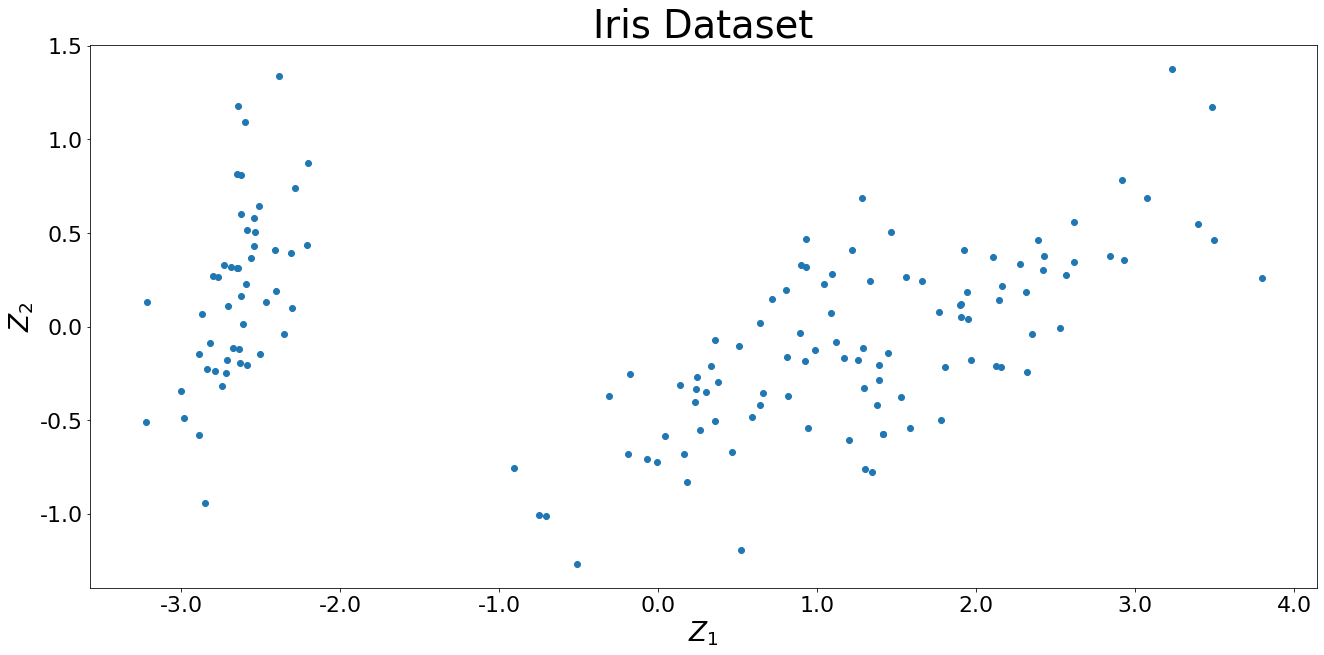

In [10]:
plot_unsup(data_iris, 22, 10, "Iris Dataset")

- The number of clusters, $k$, is a hyperparameter.

### Algorithm:

Two steps:
1.  Assign each example to the closest center.
2.  Estimate new centers as _average_ of example in a cluster.

Repeat 1. and 2. until centers and assignments do not change anymore.

- Let's use the $k$-means in the iris dataset as an example;

#### Initialization
- In this case, we know that $k=3$;
- We are going to pick three points at random to use as initial centroids;

/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': 0.8*w})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:195: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': 0.8*w})


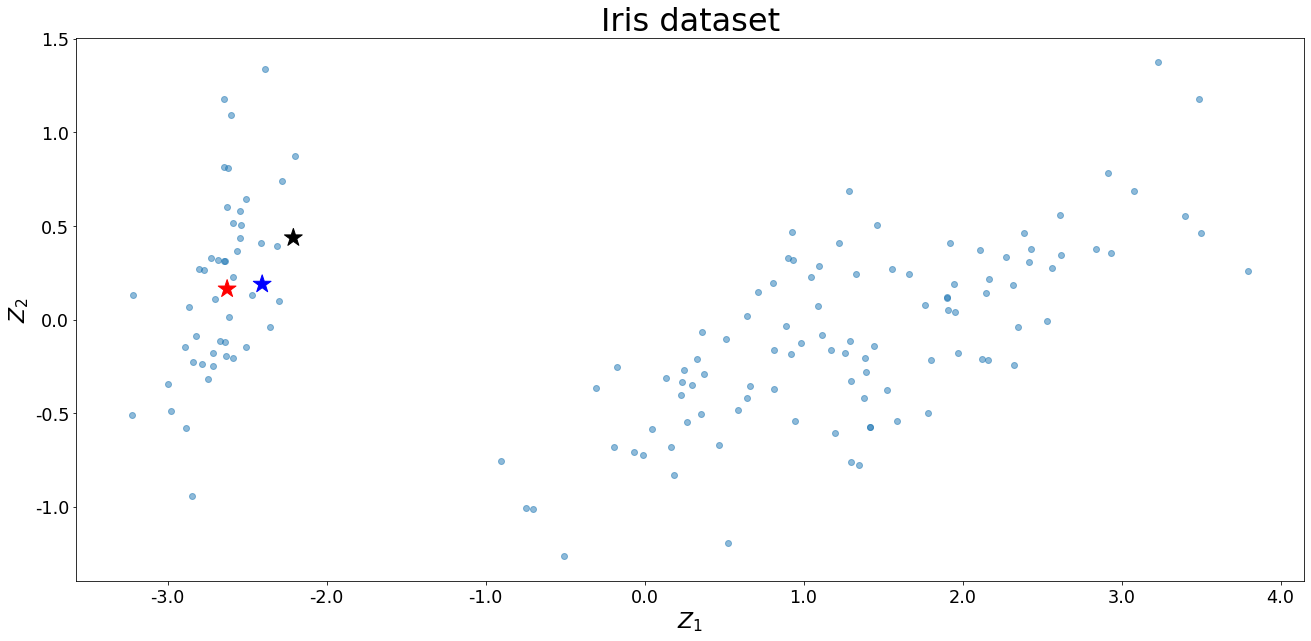

In [11]:
# RANDOM initialization 
k = 3
centroids = np.random.choice(range(0,150), size = k)
centroids = data_iris.iloc[centroids, 0:2]
plot_intial_center(data_iris, centroids, 22, 10, title="Iris dataset")

- Next, for each point in the dataset, we calculate the distance to each one of the centroids; 
- Let's do it for one point as example:

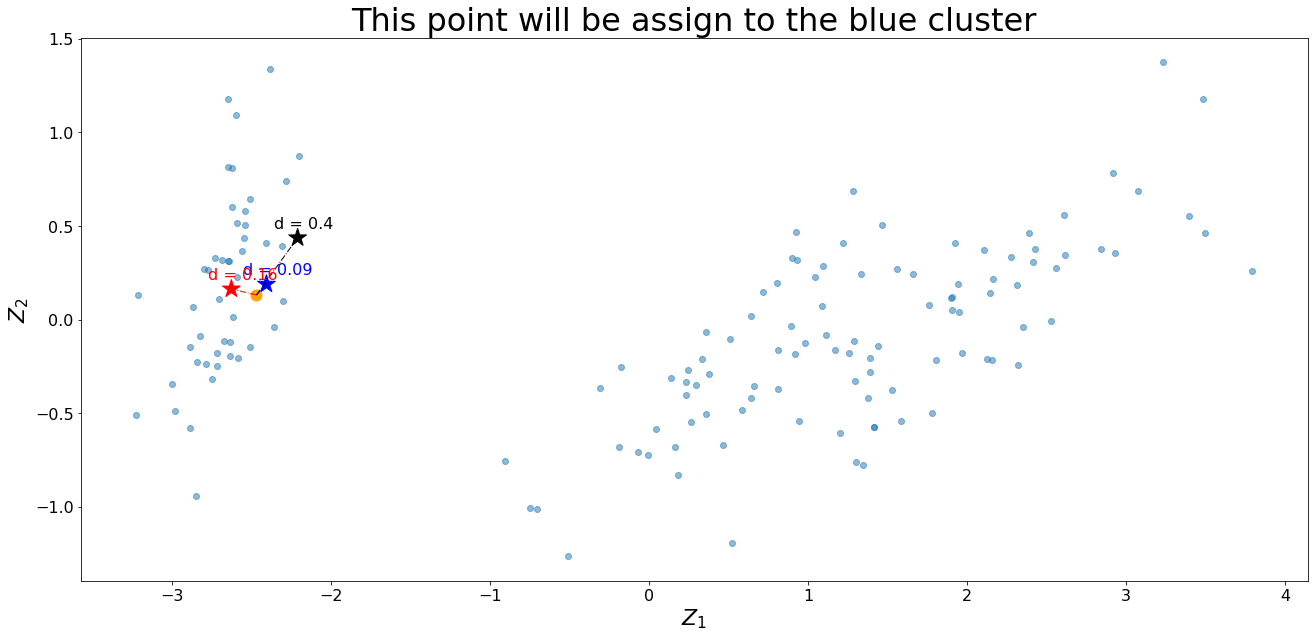

In [12]:
plot_example_dist(data_iris, centroids, 22, 10)

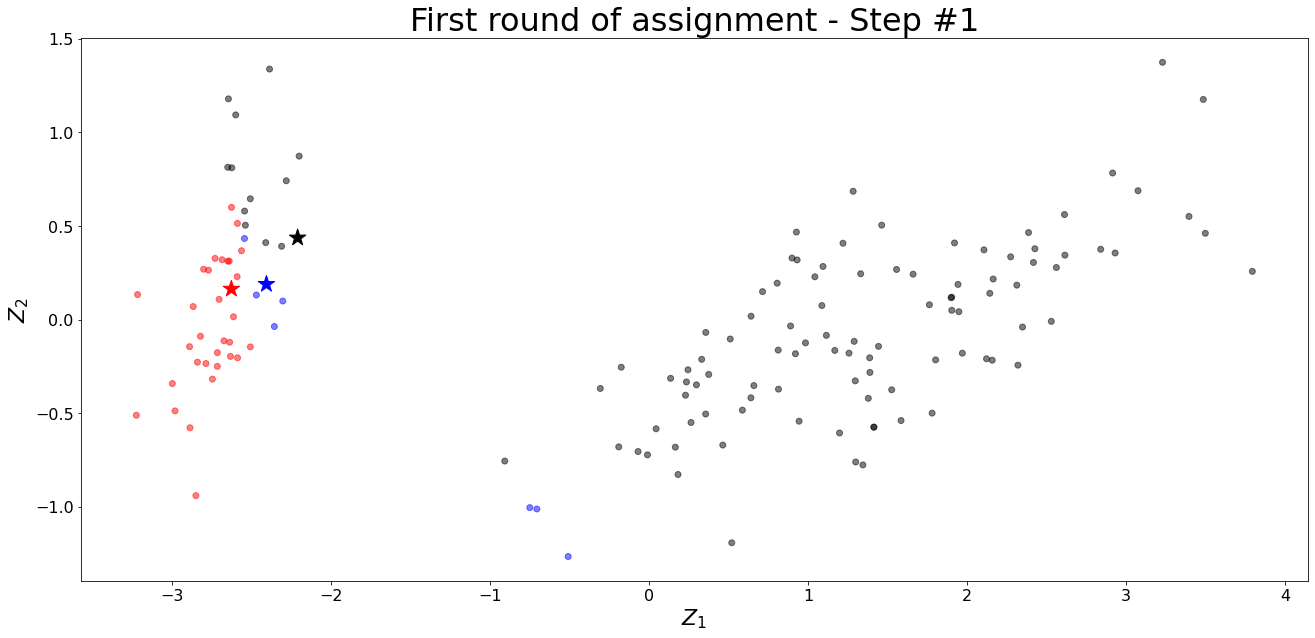

In [13]:
dist = distance.cdist(data_iris.iloc[:,0:2], centroids.iloc[:,0:2])
plot_first_assignment(data_iris, centroids, dist, 22, 10)

In [14]:
## Update the centroids
u = np.zeros((k, data_iris.shape[0]))
u[np.argmin(dist, axis=1), range(0,150)] = 1
new_centroids = u @ data_iris.iloc[:, 0:2].to_numpy() / np.sum(u,1)[:, None]

- Now, we update the centroids (Step 2);

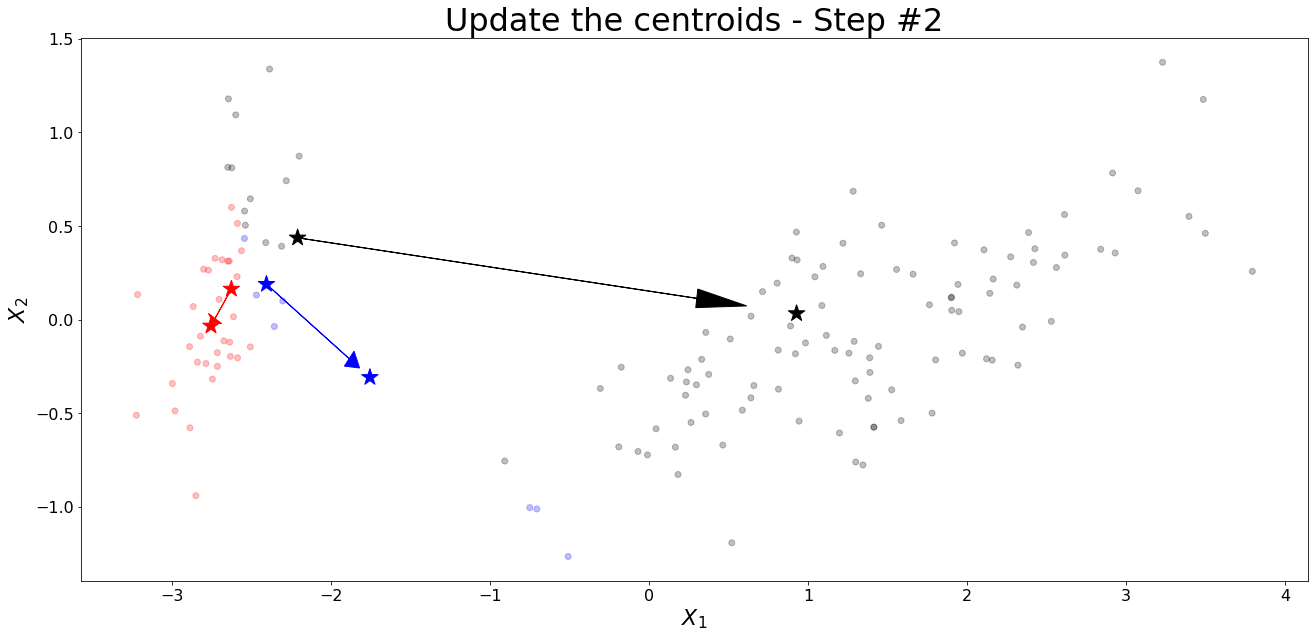

In [15]:
plot_update_centroid(data_iris, 22, 10, new_centroids, centroids.to_numpy(), dist)

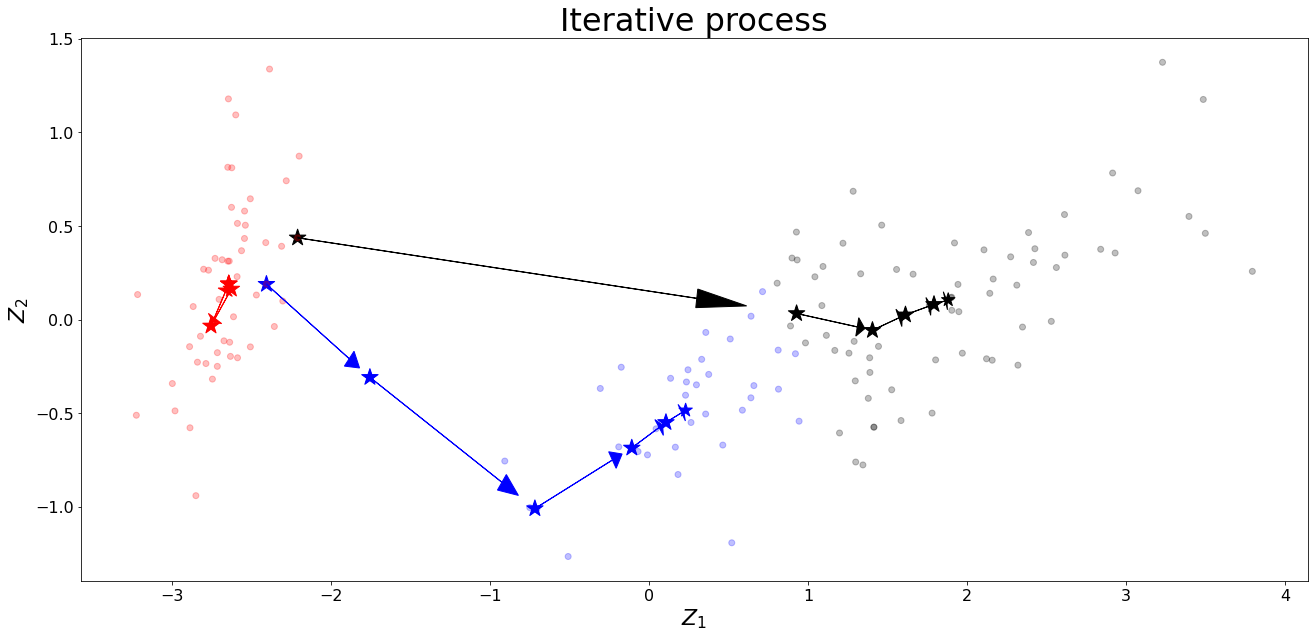

In [16]:
plot_iterative(data_iris, 22, 10, centroids.to_numpy())

#### Initialization

- The initialization of K-Means is stochastic, can this affect the results?
    - Yes! Big time.
    
    
- To see that, consider a "bad" initial centroid:

In [17]:
# Setting the seed that generates bad initial centroids 
np.random.seed(10)
bad_initial_centroid = np.random.choice(range(0,150),size = k )
bad_initial_centroid = data_iris.iloc[bad_initial_centroid,0:2]

/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': 0.8*w})
/Users/mgelbart/git/330/cpsc330/lectures/support_functions.py:195: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': 0.8*w})


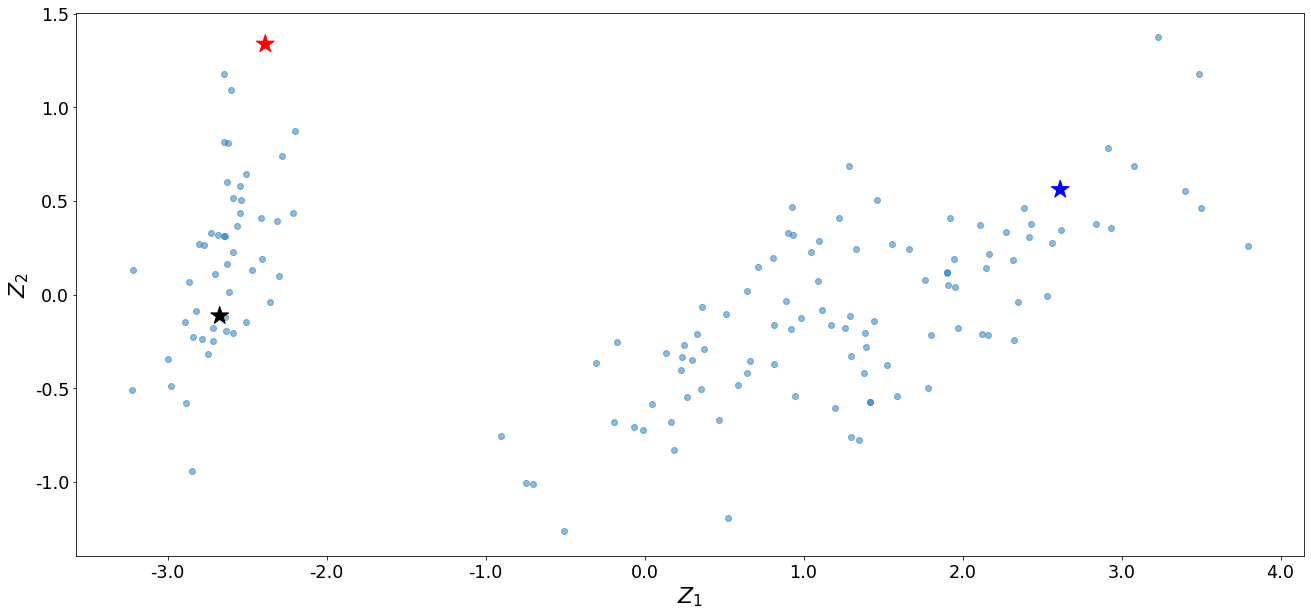

In [18]:
plot_intial_center(data_iris, bad_initial_centroid, 22, 10, )

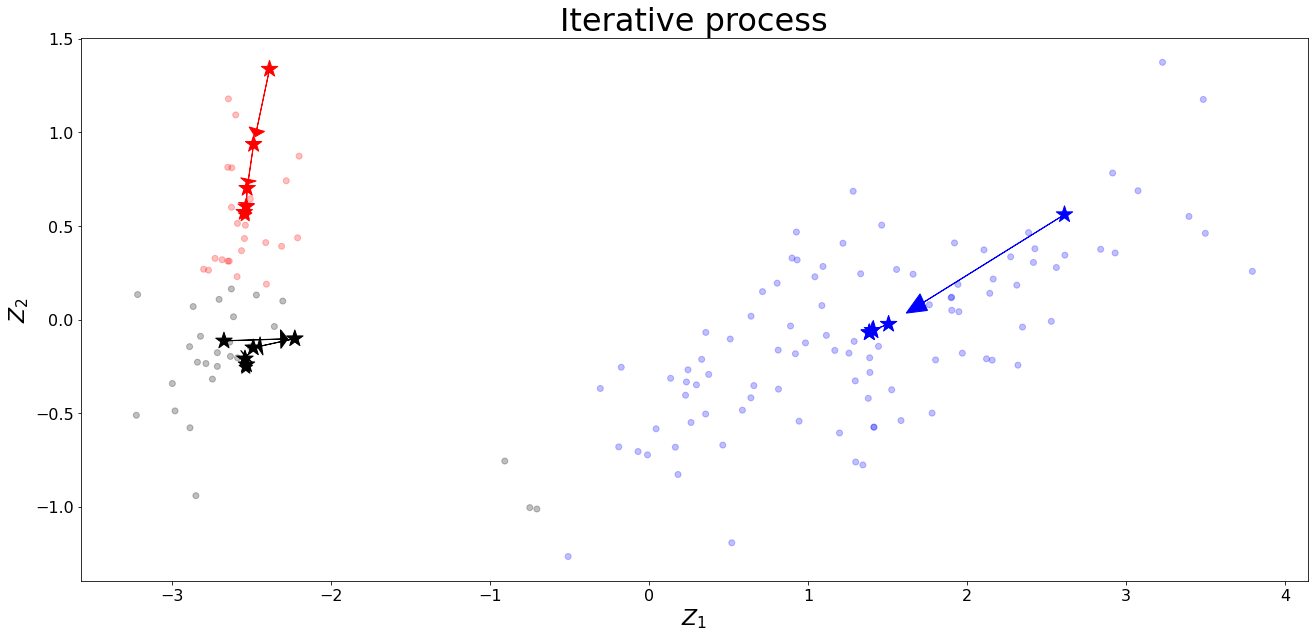

In [19]:
plot_iterative(data_iris, 22, 10, bad_initial_centroid.to_numpy())

What can we do about it?

- One strategy is to run the algorithm several times
- But is it possible to also improve the initialization process?
    - Yes! We can use the so-called [$k$-means++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).
- $k$-means++ is an initialization strategy for $k$-means.
- Intuitively, it seems a good idea to have the centroids far away from each other
- When picking the initial centroids, K-Means++ gives more chance to select points that are far away from centroids already picked
- Good news: sklearn's [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) already uses $k$-means++ as the default initialization procedure.


In [20]:
?KMeans

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    precompute_distances='deprecated',
    verbose=0,
    random_state=None,
    copy_x=True,
    n_jobs='deprecated',
    algorithm='auto',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random', ndarray, callable}, default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose `n_clusters` observations (rows) at random from data
    for the initial centroids.

    If an ndarray is passed, it should be of shape (n_clusters, n_features)
    and gives the initial centers.

    If a callable is passe

In [21]:
iris_2d = data_iris.iloc[:,:2]

In [22]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(iris_2d);

In [23]:
iris_2d.shape

(150, 2)

- Note there is no splitting here, and no `y` either.

In [24]:
kmeans.predict(iris_2d)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 0, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3,
       3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 0, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 0, 3, 4, 0, 0, 4, 2, 4, 0, 4,
       0, 0, 0, 3, 3, 0, 0, 4, 4, 3, 0, 3, 4, 3, 0, 4, 3, 3, 0, 0, 4, 4,
       0, 3, 0, 4, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3], dtype=int32)

In [25]:
kmeans.cluster_centers_

array([[ 2.06744818,  0.11382422],
       [-2.64241546,  0.19088505],
       [ 0.0476426 , -0.58046141],
       [ 1.09999992, -0.13597732],
       [ 3.1280555 ,  0.62956268]])

$k$-means summary:

- It always converges;
- Each object is assigned to one (and only one) cluster;
- It depends on the choice of the initial centers; thus, it may converge to sub-optimal solution;
- You may want to run it several times (see `n_inits` argument);
- The centroids are not actual data points, but instead are average points;

Question: could there be a deployment phase for clustering?

<br><br><br><br><br><br>

- Yes, e.g. what sauce would a new person buy?
- Let's check for a person with features $(0,0)$

In [26]:
kmeans.predict(np.zeros((1,2)))

array([2], dtype=int32)

Question: name 3 situations in which clustering might be useful.

<br><br><br><br><br><br>

## Choosing $k$ (10 min)

- Since in unsupervised learning we do not have the $y$ values, it becomes very difficult to objectively measure the effectiveness of the algorithms.
- There is no definitive approach.
- However, some strategies might be useful to help you determine $k$.

#### The Elbow method

- Find a measure of how well the clusters "fit" the data
  - Often the sum of intra-cluster distances, aka _inertia_.
  - Question: would we want this to be small or large?

<br><br><br><br><br><br>

- The problem is, we can't just look for a $k$ that minimizes the sum of intra-cluster distance because it decreases as $k$ increases.
- But we can evaluate the trade-off: "small k" vs "small intra-cluster distances".

In [27]:
x = data_iris.iloc[:, 0:2].to_numpy()
kmeans = list()
n_clusters_list = list(range(1,10))

for k in n_clusters_list:
    kmeans.append(KMeans(n_clusters = k, random_state=1).fit(x))

In [28]:
def plot_elbow(w, h, kmeans):
    plt.figure(figsize = (w,h))
    plt.axvline(x=3, linestyle='-.', c="black")
    plt.plot(n_clusters_list, [k.inertia_ for k in kmeans], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

63.81994202200125

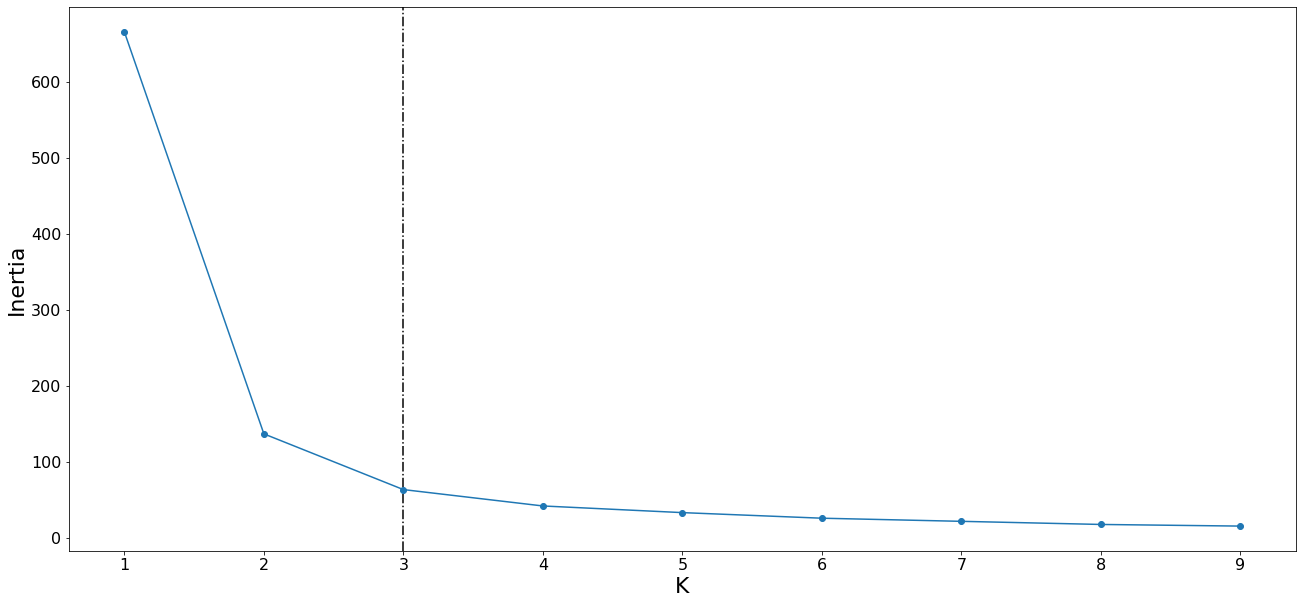

In [29]:
plot_elbow(22,10, kmeans)
# We could argue between two and three clusters are enough;
kmeans[2].inertia_

#### The Silhouette method


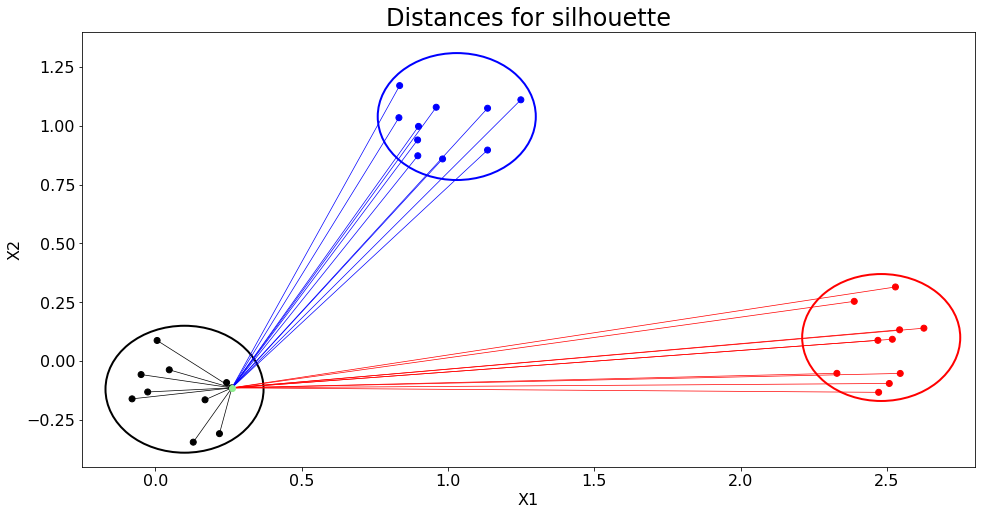

In [30]:
plot_silhouette_dist(16, 8)

First step: find the _second best_ cluster for each point.

- Average the distances of the green point to the other points in the same cluster.
  - These distances are represented  by the black lines;
  

- Average the distances of the green point to the points in the <font color="blue">blue</font> cluster;
  - These distances are represented  by the <font color="blue">blue</font> lines;


- Average the distances of the green point to the points in the <font color="red">red</font> cluster;
  - These distances are represented  by the  <font color="red">red</font>  lines;

Then, since the average distance to the blue cluster is lower than to the red cluster, the blue cluster is considered to be the neighbour cluster - (the second-best choice for the green point to live, after the black cluster). 

The silhouette method compares the average distance to the neighbour cluster to the average distance to the given cluster to come up with a silhouette coefficient for that example (`sklearn.metrics.silhouette_samples`).

- Unlike the inertia, **larger values are better** because they indicate that the point is further away from neighbouring clusters.
- Unlike the inertia, the overall silhouette score gets **worse** as you add more clusters because you end up being closer to neighbouring clusters. 
  - Thus, as with intertia, you will not see a "peak" value of this metric that indicates the best number of clusters.
- We can visualize the silhouette score for each example individually in a silhouette plot (hence the name), see below.
  - (I guess it should be possible to do this with the inertia/distance as well, but I haven't seen it done. Maybe because the score are not normalized?)

Attribution: the following code is adapted from the sklearn docs [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

In [31]:
def make_sklearn_sil_plots(X, params_list=None, clusterer_class=KMeans):

    if params_list is None:
        params_list = [{"n_clusters" : n} for n in range(2,10)]
    
    clusterers = [clusterer_class(**params).fit(X) for params in params_list]
    
    for nn, clusterer in enumerate(clusterers):
        n_clusters = np.max(clusterer.labels_) + 1
        
        # Create a subplot with 1 row and 2 columns
        
        if X.shape[1] == 2:
            fig, (ax1, ax2) = plt.subplots(1, 2)
        else:
            fig, ax1 = plt.subplots(1, 1)

        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#         cluster_labels = clusterer.predict(X)
        cluster_labels = clusterer.labels_

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        if X.shape[1] == 2:
            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k')

            # Labeling the clusters
            try:
                centers = clusterer.cluster_centers_
            except AttributeError:
                pass
            else:
                # Draw white circles at cluster centers
                ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c="white", alpha=1, s=200, edgecolor='k')

                for i, c in enumerate(centers):
                    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                                s=50, edgecolor='k')

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for " + clusterer_class.__name__ +
                      " with %s" % params_list[nn]),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7056703225102109
For n_clusters = 3 The average silhouette_score is : 0.597676421954799
For n_clusters = 4 The average silhouette_score is : 0.5577409232246783
For n_clusters = 5 The average silhouette_score is : 0.5515547785513799
For n_clusters = 6 The average silhouette_score is : 0.445945182029375
For n_clusters = 7 The average silhouette_score is : 0.437439232459205
For n_clusters = 8 The average silhouette_score is : 0.4457597415979585
For n_clusters = 9 The average silhouette_score is : 0.43381014031564075


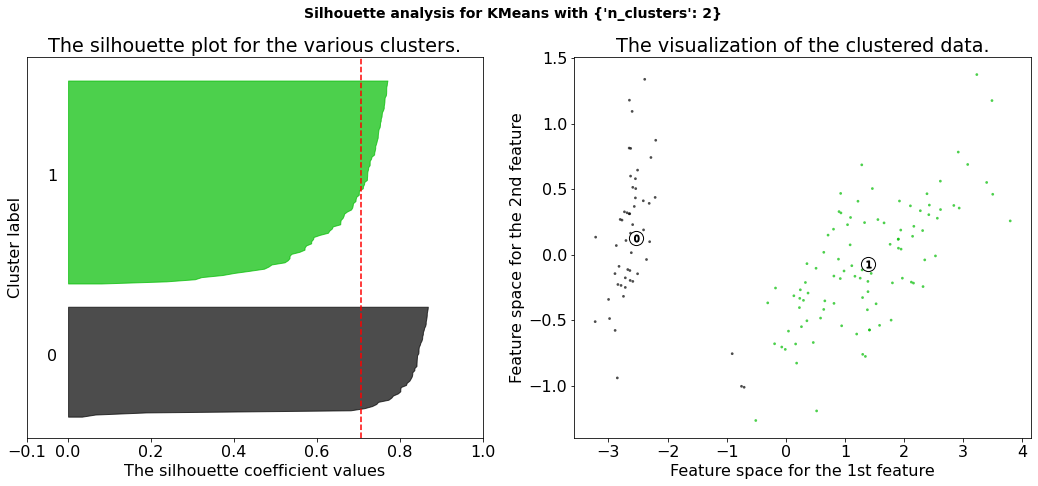

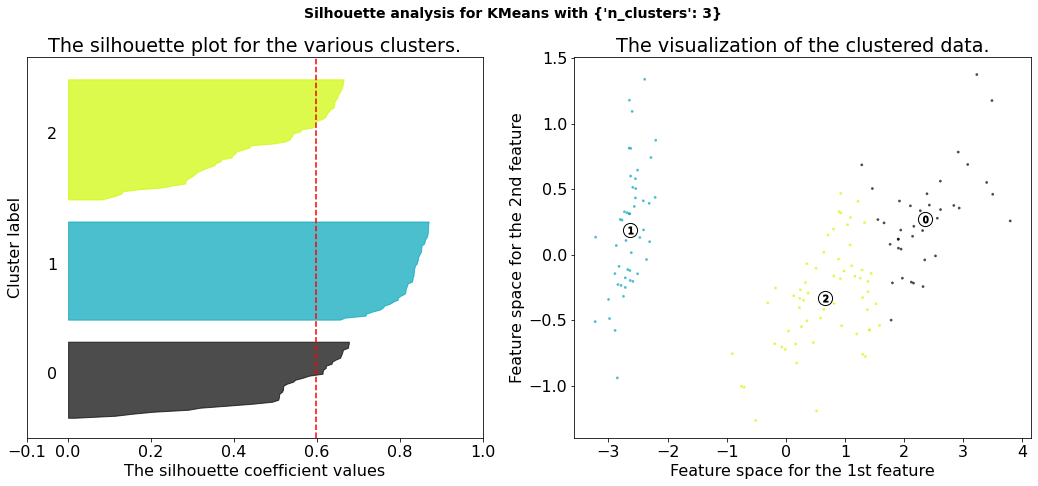

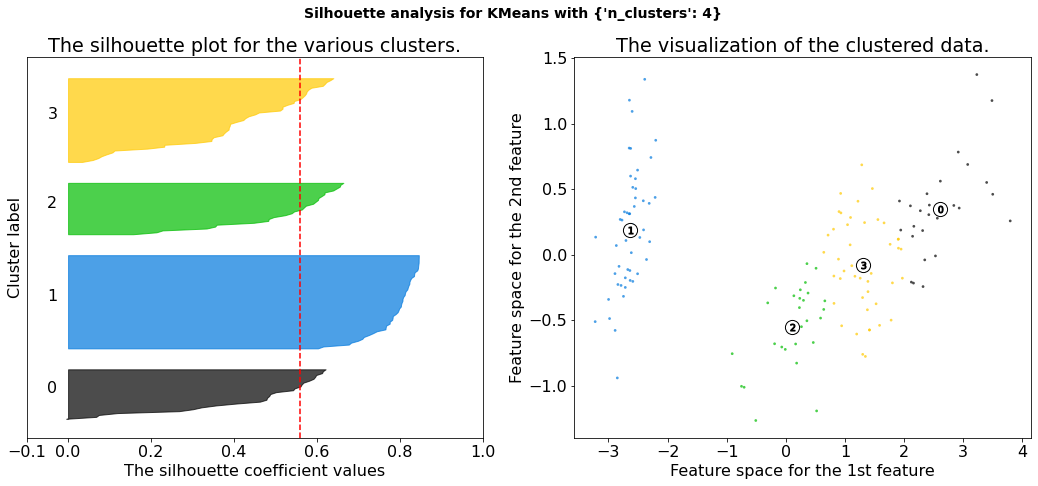

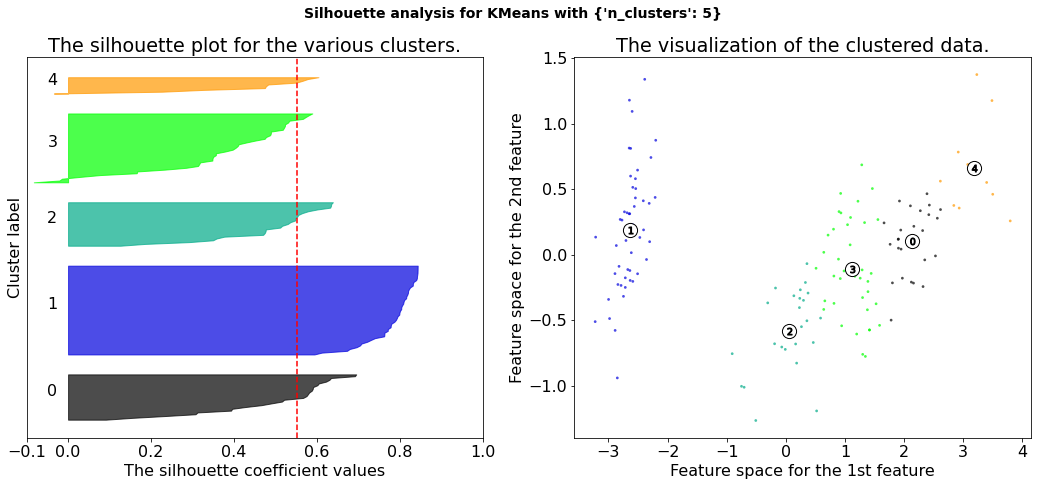

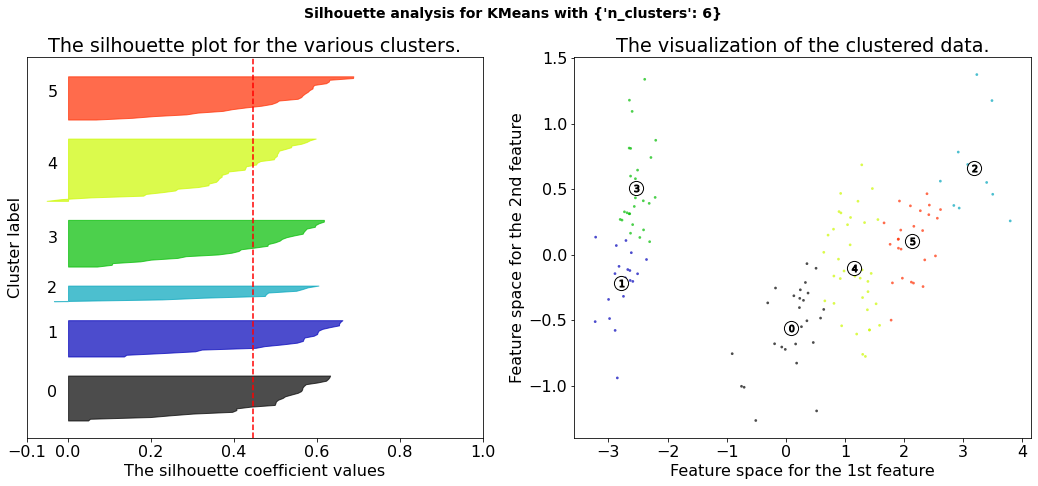

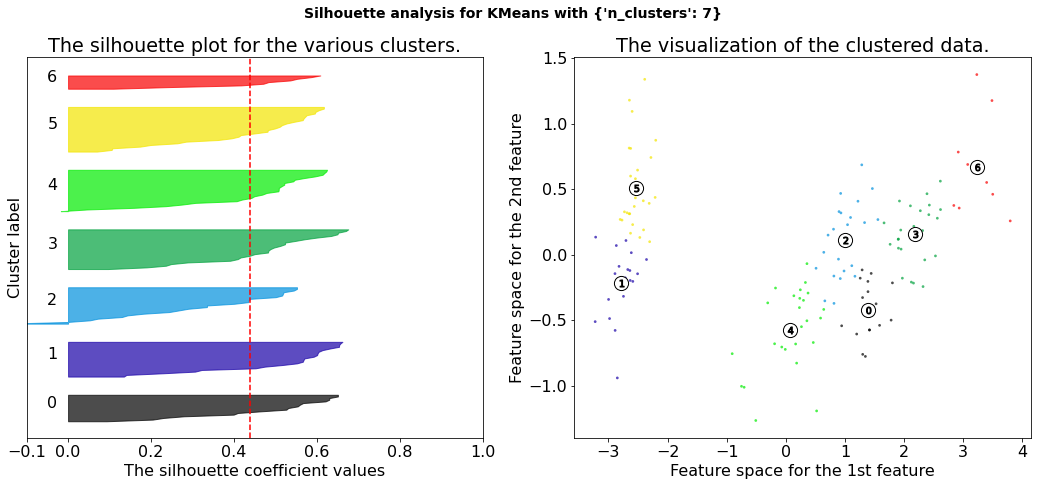

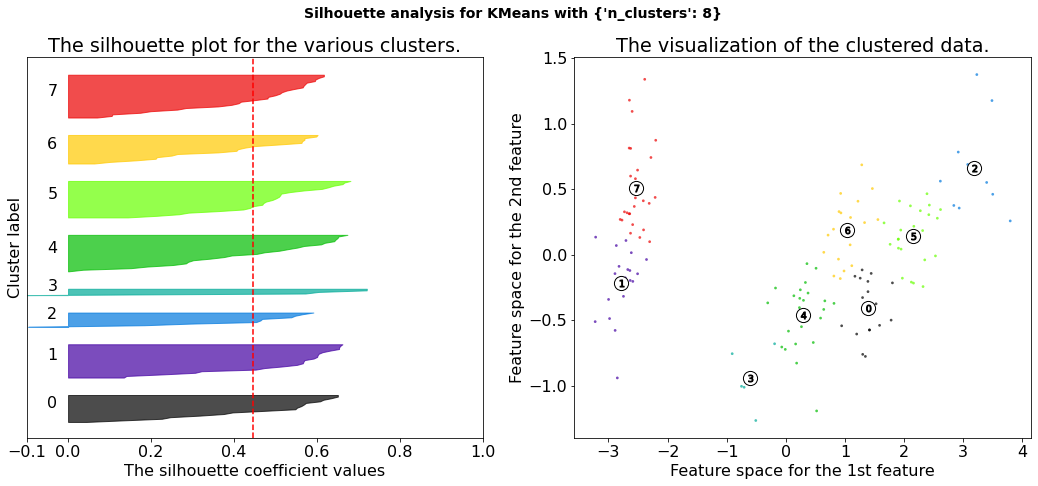

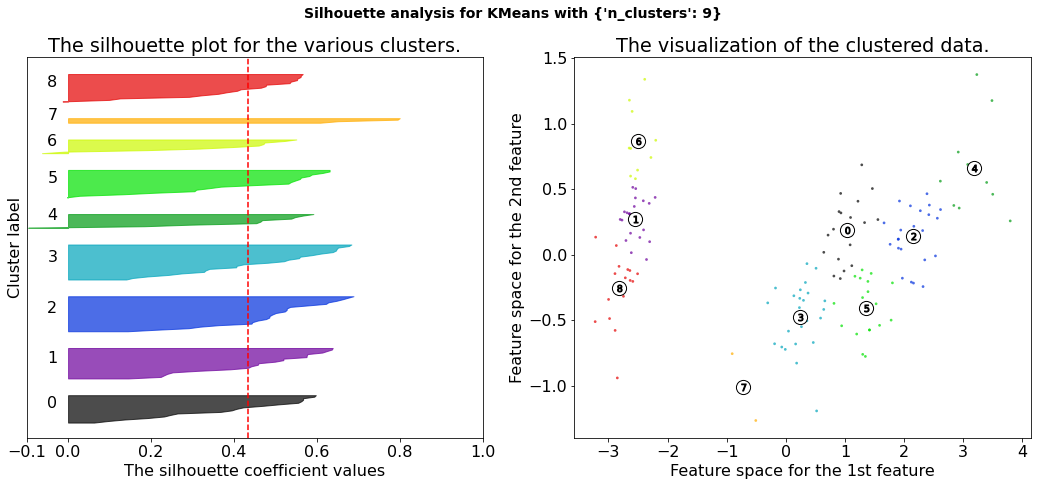

In [32]:
make_sklearn_sil_plots(x)

What to look for in these plots:

- The thickness of each silhouette indicates the cluster size.
- The shape of each silhouette indicates the "goodness" for points in each cluster.
- The length (or area) of each silhouette indicates the goodness of each cluster.

For example, with $n=2$ or $n=3$ above we have "thick" silhouettes.

- One can also plot an overall silhouette score for each number of clusters.
- The overall index (`sklearn.metrics.silhouette_score`) is the average across all examples.

In [33]:
def plot_silhouette(w,h,x,kmeans):
    s = [metrics.silhouette_score(x,kmeans[k-1].labels_) for k in range(2,10)]
    plt.figure(figsize=(22,10))
    plt.plot(range(2,10), s);
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("s", fontsize=w)
    ax.set_title("Silhouette: Iris Dataset with $k$-means partitions", fontsize=w+h)
    ax.axvline(x=2, c='black', linestyle='-.')

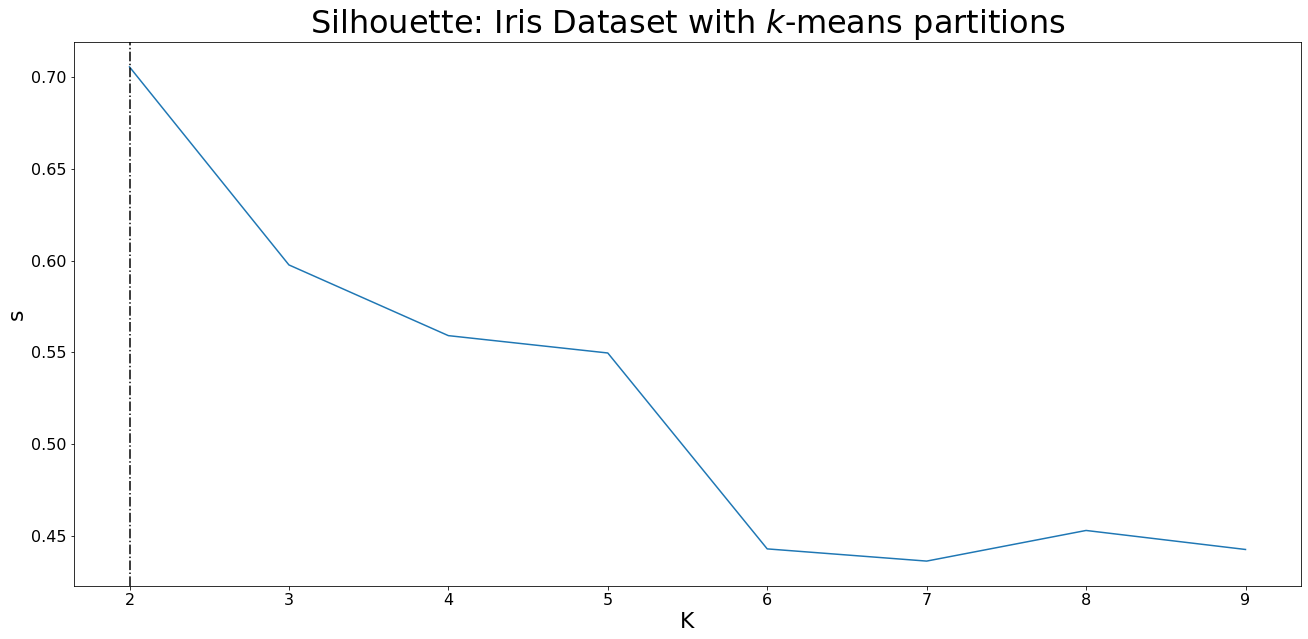

In [34]:
plot_silhouette(22,10,x,kmeans)

As mentioned above, this looks similar to an inertia plot but

- Higher is better
- Things get worse with more clusters
- These two effects cancel out and you get the curve going downward as you add more clusters!

In [35]:
from load_process_data import load_housing

ModuleNotFoundError: No module named 'load_process_data'

In [ ]:
X_train_enc, X_valid_enc, X_test_enc, _, _, _ = load_housing()

Here, we won't see clusters because we have more than 2 features.

In [ ]:
# make_sklearn_sil_plots(X_train_enc)

In [ ]:
kmeans_housing = [KMeans(n_clusters = k).fit(X_train_enc) for k in range(1,10)]

In [ ]:
plot_silhouette(22,10,X_train_enc,kmeans_housing)

- The silhouette coefficients are technically between $-1$ and $+1$ but typically between $0$ and $+1$ (sort of like $R^2$).
  - $0$ means close to another cluster, $+1$ means far from other clusters (good)
- The silhouette method can be used with any clustering algorithm. 

## Distance metrics (10 min)

- Distances metrics are used to measure the dissimilarity between points.
- There are many different distance measures out there, such as Euclidean, Mahalanobis, and Minkowsky distances.

#### Example: Euclidean distance

In [36]:
S = np.cov(x[50:100], rowvar=False)
eig = np.linalg.eig(S)
e1 = eig[1][:,0] # First eigenvector
e2 = eig[1][:,1] # Second eigenvector

# Parameters for the ellipse
angle = np.arccos(np.dot(eig[1][:,0], [1,0])/(np.linalg.norm(eig[1][:,0])))
angle = np.rad2deg(angle)

desired_distance = 1 # Just the distance value you want
width = 2*desired_distance * np.sqrt(eig[0][0])
height = 2*desired_distance * np.sqrt(eig[0][1])

In [37]:

def plot_dist_example(w, h, distance="both"):
    plt.close()
    fig, ax = plt.subplots(figsize=(w, h))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("$X_1$", fontsize = (w+h))
    ax.set_ylabel("$X_2$", fontsize = (w+h))
    ax.axis("equal")
    ax.scatter(x[50:100,0], x[50:100,1])
    

    # Center point
    i = 69
    center = x[i,:]
    ax.scatter(x[i,0], x[i,1], c="red", s=100, marker="*",zorder=10)
    title=""
    #Creating the ellipses
    if distance=="euclidean" or distance=="both":
        euclidean_ellipse = Ellipse(xy=center, width=2*1, height=2*1, angle=angle, alpha = 0.2, color="green")
        ax.add_patch(euclidean_ellipse)    
        ax.scatter([],[], alpha=0.2, s=500, c="green", label="Euclidean $\leq$ 1")
        title="Euclidean distance"

    if distance=="mahalanobis" or distance=="both":
        #changes the color of the points considered for the covariance matrix
        mahalanobis_ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, alpha=0.2, color="blue")
        ax.scatter(x[50:100,0], x[50:100,1], c="green")
        ax.add_patch(mahalanobis_ellipse)
        ax.scatter([],[], alpha=0.2, s=500, c="blue", label="Mahalanobis $\leq$ " + str(desired_distance))
        title="Mahalanobis distance"
    
    if distance=="both":
        title="Euclidean and Mahalanobis distances"
    
    ax.legend(fontsize=16)
    ax.set_title(title, fontsize=26)

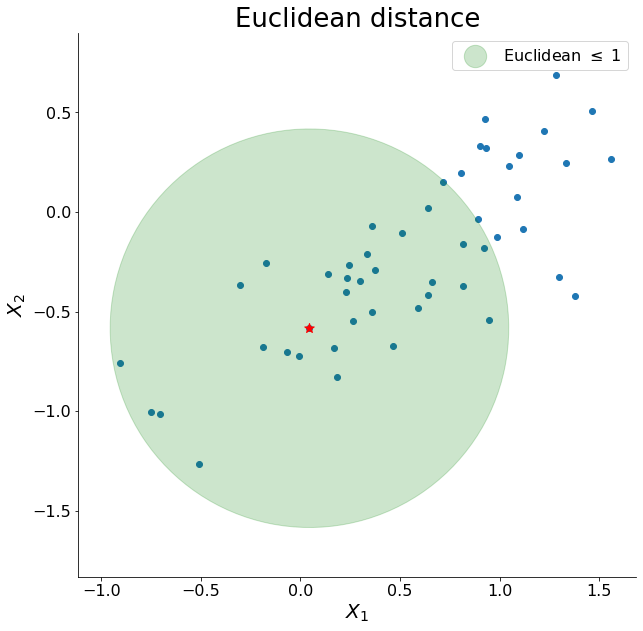

In [38]:
plot_dist_example(10,10, "euclidean")

#### Example: Mahalanobis distance

- This allows you to prioritize different directions, can help if columns are not scaled.

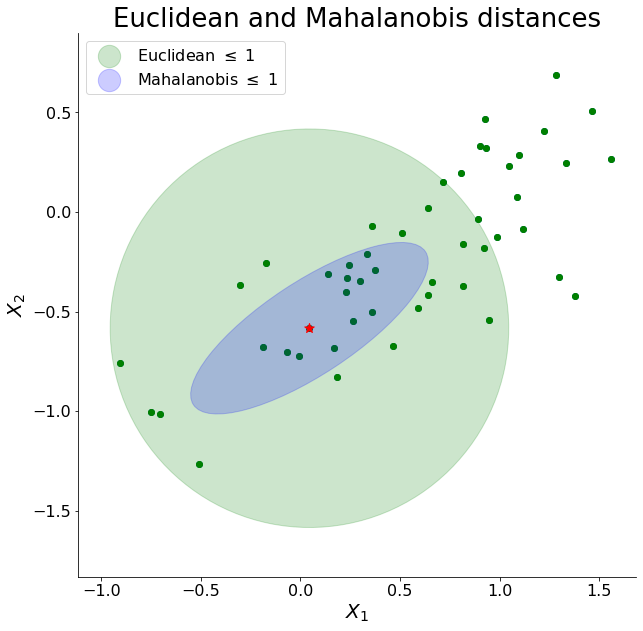

In [39]:
plot_dist_example(10,10, "both")

The function `scipy.spatial.distance.cdist` is very helpful for calculating distance.
  - Be very careful when using Euclidean distance on non-scaled data.
- Although this might look just as required step to introduce the clustering algorithms, this is a fundamental step: 
<blockquote cite="http://www.worldwildlife.org/who/index.html">
<i> "Specifying an appropriate dissimilarity measure is far more important in obtaining success with clustering than choice of clustering algorithm."</i>
 (Hastie, Tibshirani & Friedman, The Elements of Statistical Learning, 2nd Edition, p. 506).
</blockquote>

- Defining the distance to be used by the clustering algorithm is how we answer the question: what is similar?
- However, selecting an appropriate distance measure is very tricky and there is no general methodological recipe for it.
- This requires _domain knowledge_.

Example: our housing data.

In [40]:
df = pd.read_csv("data/week_05_house-prices/train.csv")
df.head()

FileNotFoundError: [Errno 2] File data/week_05_house-prices/train.csv does not exist: 'data/week_05_house-prices/train.csv'

Question: do we need to transform our data to numeric?

<br><br><br><br><br><br>

- Well, not necessarily, if our distance function can take in the right data type!
- For example in our New York Airbnb data, we could look at the actual distance between neighbourhoods. 
- Here, we could account for the month sold issue that 1=Jan and 12=Dec.

See sklearn's [SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) with `affinity='precomputed'`.

## Break (5 min)

## DBSCAN (10 min)

In [41]:
# Generating sample datasets for a motivating figure;
x1 = np.random.multivariate_normal(mean = [0,0], cov=np.diag([3,3]), size = 200)
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [-7,-7], cov=np.diag([1,1]), size = 50)))
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [7,-7], cov=np.diag([1,1]), size = 50)))
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [9,4], cov=np.diag([1,1]), size = 50)))

x2 = datasets.make_circles(n_samples=200, noise=.06, factor=.4)[0]

x3 = np.random.uniform(-1,1,size=100)
x3 = np.column_stack((x3,x3**3+np.random.normal(scale=.08,size=100)))
x3 = np.concatenate((x3,np.random.multivariate_normal(mean = [-1,1], cov=np.diag([.025,.025]), size = 50)))
x3 = np.concatenate((x3,np.random.multivariate_normal(mean = [1,-1], cov=np.diag([.025,.025]), size = 50)))
x3 = np.concatenate((x3,np.column_stack((np.random.uniform(-2,2,size=20),np.random.uniform(-2,2,size=20)))))
datasets.make_blobs()

def plot_example_density(w,h):
    fig, ax = plt.subplots(1,3,figsize=(w,h))
    ax[0].scatter(x1[:,0],x1[:,1]);
    ax[1].scatter(x2[:,0],x2[:,1]);
    ax[2].scatter(x3[:,0],x3[:,1]);
    ax[0].set_title("How many clusters?", fontsize=w)
    ax[1].set_title("How many clusters?", fontsize=w)
    ax[2].set_title("How many clusters?", fontsize=w)


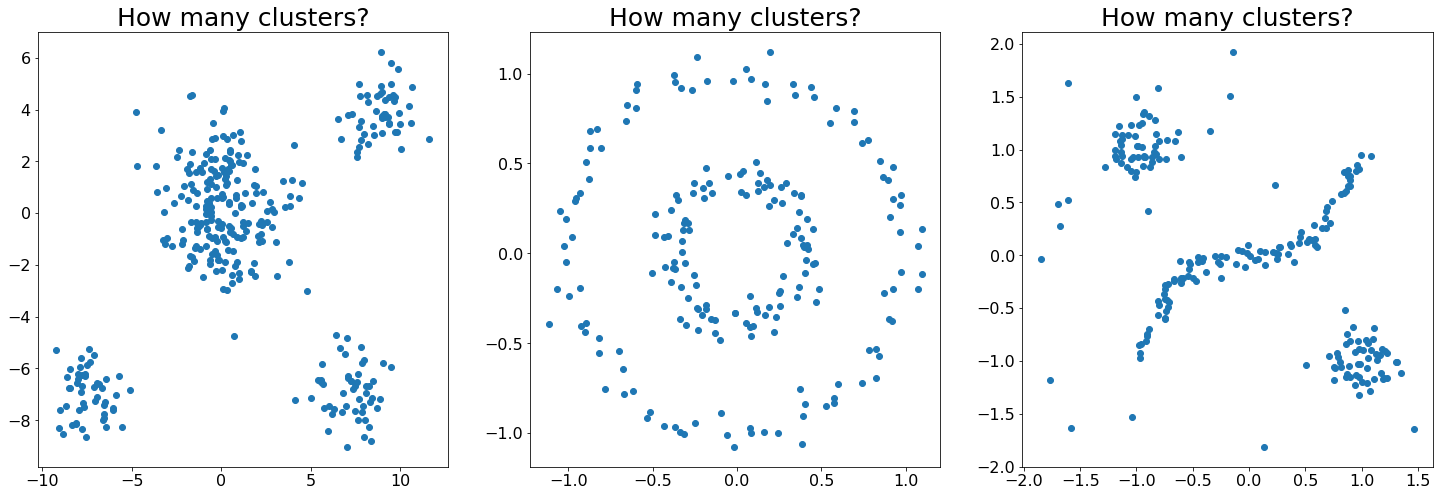

In [42]:
plot_example_density(25,8)

**Question:** How can we tell how many clusters in the plot above?

<br><br><br><br><br><br>

One definition is that, inside the clusters we have higher density of points than outsides the clusters;

#### Let's work with the idea of density

- We will say that, to be part of a cluster, each point must have at least _some number of neighbors_ in a given _radius_. 

To work with this idea, we need three things:

   - Define how many neighbor points we require.
   - The neighborhood size parameter.
   - The neighborhood shape: this will be defined by the distance metric used.

In [43]:
?DBSCAN

Init signature:
DBSCAN(
    eps=0.5,
    *,
    min_samples=5,
    metric='euclidean',
    metric_params=None,
    algorithm='auto',
    leaf_size=30,
    p=None,
    n_jobs=None,
)
Docstring:     
Perform DBSCAN clustering from vector array or distance matrix.

DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
Finds core samples of high density and expands clusters from them.
Good for data which contains clusters of similar density.

Read more in the :ref:`User Guide <dbscan>`.

Parameters
----------
eps : float, default=0.5
    The maximum distance between two samples for one to be considered
    as in the neighborhood of the other. This is not a maximum bound
    on the distances of points within a cluster. This is the most
    important DBSCAN parameter to choose appropriately for your data set
    and distance function.

min_samples : int, default=5
    The number of samples (or total weight) in a neighborhood for a point
    to be considered as a core point. T

- DBSCAN clustering works this way, and can fit shapes than $k$-means cannot.
- We will not go into the details (it classifies each point as either a "core point" or "border point").


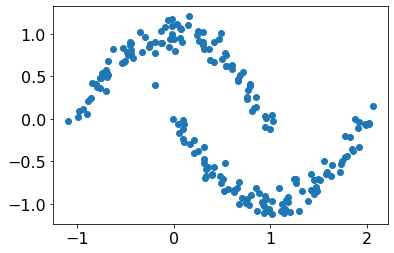

In [44]:
n1 = 100
x1 = np.linspace(-1,1,n1) + np.random.randn(n1)*.1
y1 = 1-x1**2 + np.random.randn(n1)*.1
n2 = 100
x2 = np.linspace(0,2,n2) + np.random.randn(n2)*.1
y2 = (x2-1)**2-1 + np.random.randn(n2)*.1
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
plt.scatter(x,y)
X = np.concatenate((x[:,None],y[:,None]),axis=1)

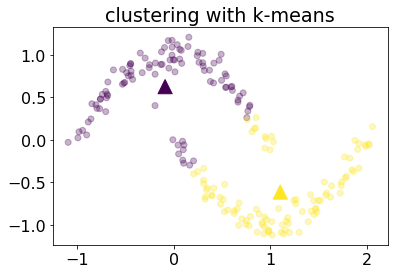

In [45]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)
plt.title("clustering with k-means");

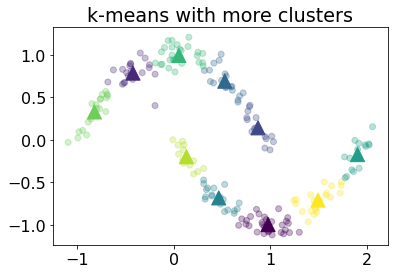

In [46]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)
plt.title("k-means with more clusters");

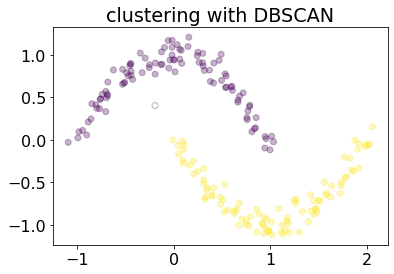

In [47]:
dbscan = DBSCAN(eps=0.3)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)
plt.title("clustering with DBSCAN");

#### Effect of the DBSCAN hyperparameters

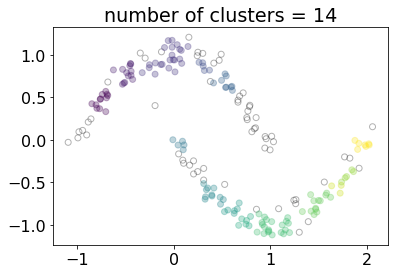

In [48]:
dbscan = DBSCAN(eps=0.1)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

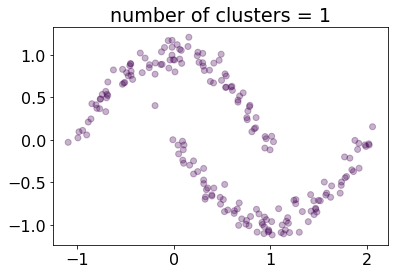

In [49]:
dbscan = DBSCAN(eps=1)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

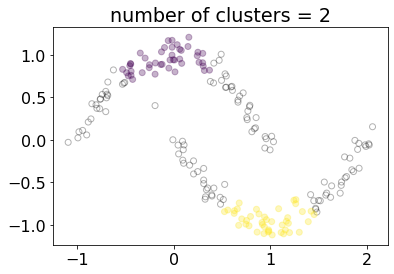

In [50]:
dbscan = DBSCAN(eps=0.3, min_samples=25)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

#### An example where $k$-means works better

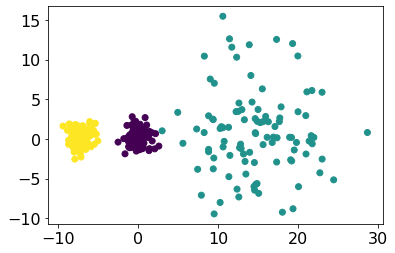

In [51]:
n1 = 100
μ1 = [0,0]
σ1 = 1
X1 = σ1*np.random.randn(n1,2) + μ1

n2 = 100
μ2 = [15,0]
σ2 = 5
X2 = σ2*np.random.randn(n2,2) + μ2

n3 = 100
μ3 = [-7,0]
σ3 = 1
X3 = σ3*np.random.randn(n3,2) + μ3


X = np.concatenate((X1,X2,X3))
z_true = np.concatenate((np.zeros(n1),np.ones(n2),np.ones(n2)+1))

plt.scatter(X[:,0],X[:,1], c=z_true);

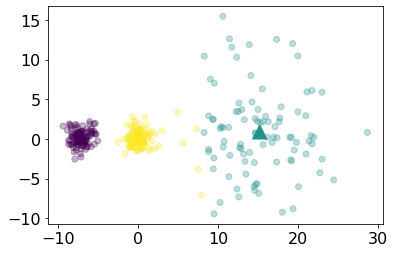

In [52]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)

$k$-means performs reasonably here, although of course it gets the benefit of me telling it the true number of clusters.

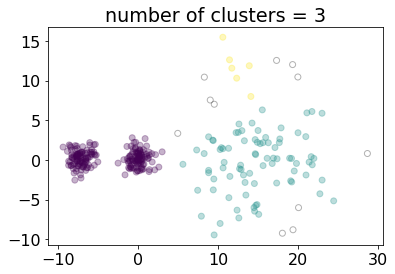

In [53]:
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

This doesn't look too great. You can try fiddling with the hyperparameters of DBSCAN here. The example is problematic because we have two different densities of clusters, and yet the `eps` parameter roughly sets a single density of cluster that we're looking for. If we make `eps` large enough to keep the non-dense (right-hand) cluster together, then it'll also end up joining the left two clusters.

Comparing $k$-means vs. DBSCAN:

For n_clusters = 2 The average silhouette_score is : 0.6785522080781823
For n_clusters = 3 The average silhouette_score is : 0.6417129664713033
For n_clusters = 4 The average silhouette_score is : 0.6012206078283682


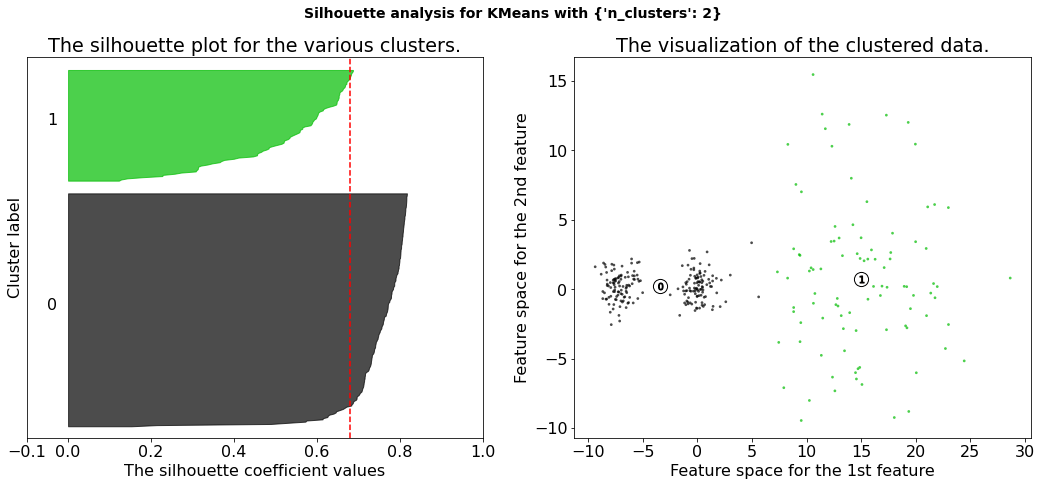

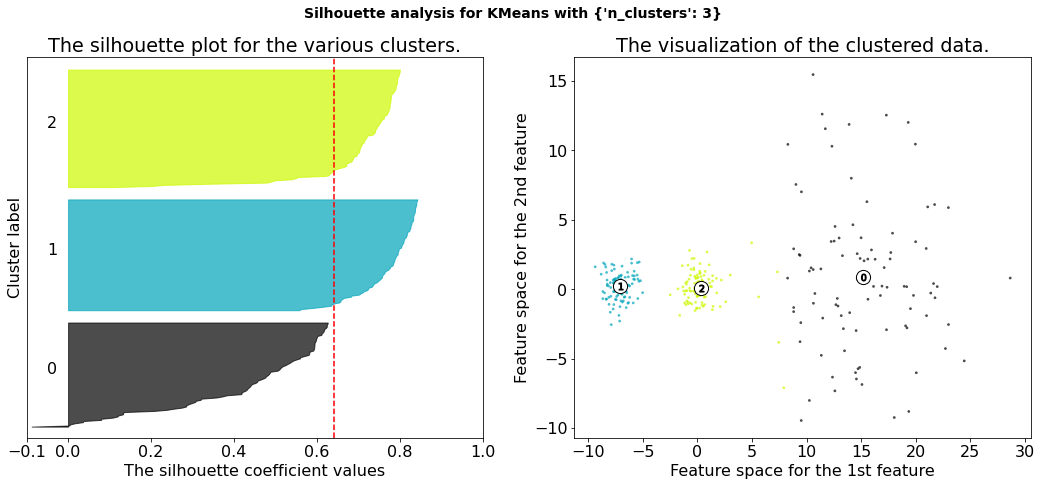

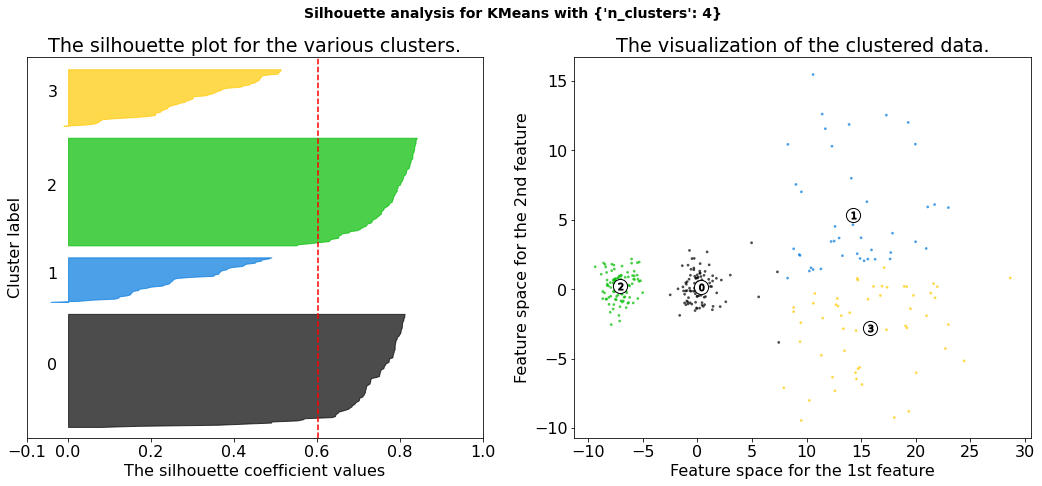

In [54]:
make_sklearn_sil_plots(X, [{"n_clusters" : n} for n in [2,3,4]])

We can make the plots for DBSCAN as well, although we have to decide how to handle un-assigned points (currently ignoring them):

For n_clusters = 5 The average silhouette_score is : 0.4178321058632639
For n_clusters = 3 The average silhouette_score is : 0.5792392305499502
For n_clusters = 3 The average silhouette_score is : 0.5977756154907293


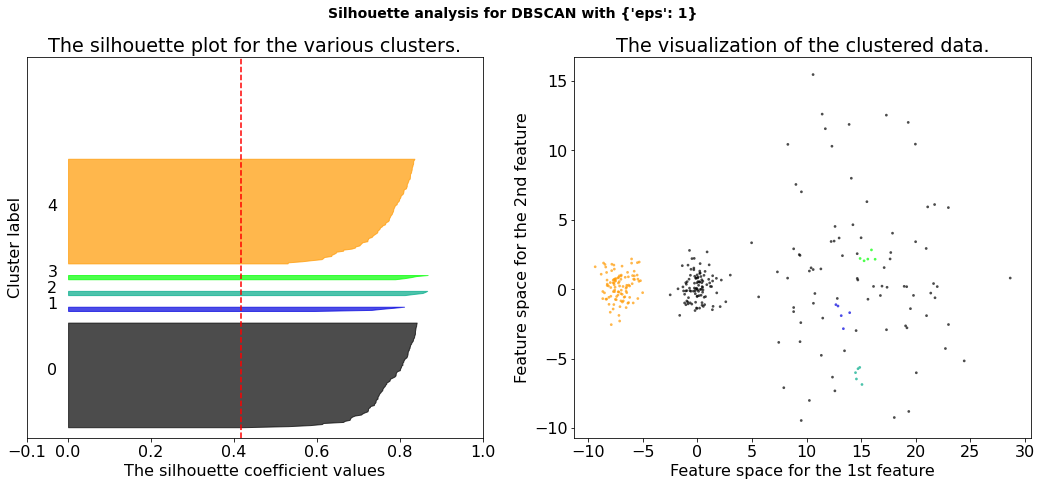

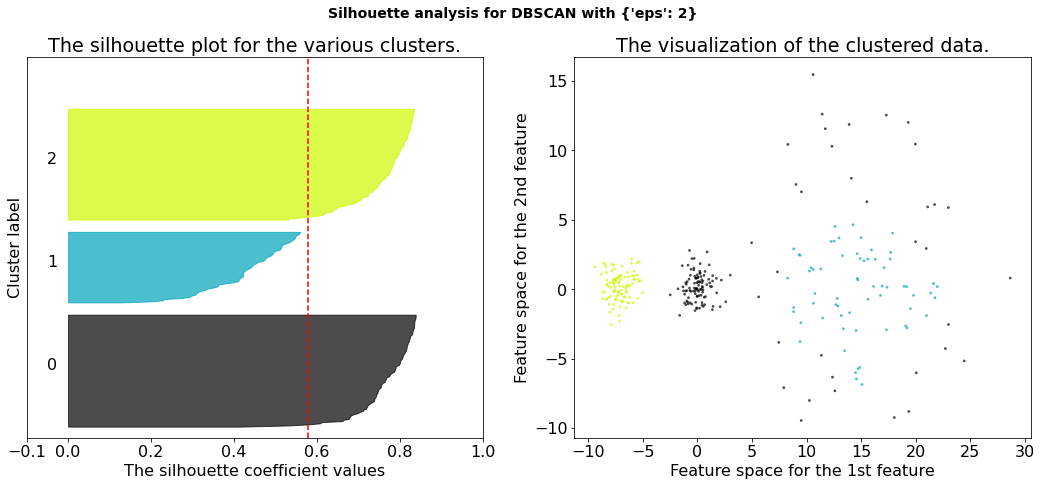

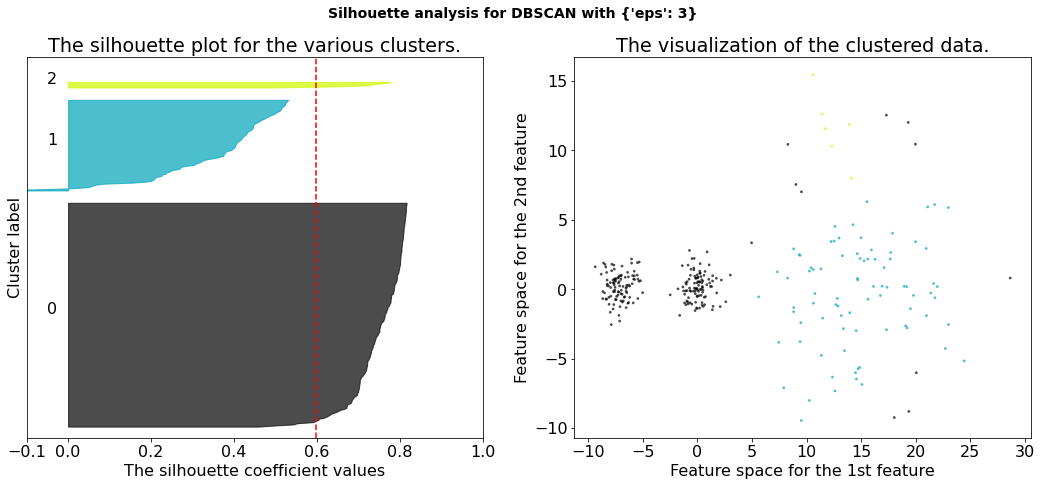

In [55]:
make_sklearn_sil_plots(X, [{"eps" : eps} for eps in [1,2,3]], DBSCAN)

In [56]:
np.max(dbscan.labels_) + 1

3

There's a nice comparison of sklearn clustering algorithms [here](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods).

## Hierarchical Clustering (10 min)

- Looking at the previous plot, maybe the two smaller clusters on the left are sub-clusters of a larger left cluster?
- Solution: in a step-by-step way, merge (or divide) the existing clusters.

#### Agglomerative Clustering

- Agglomerative clustering works by merging clusters.
- The overall idea is.
    1. Start with each point as a separate cluster.
    2. Merge the clusters that are most similar to each other.
    3. Repeat Step 2 until you obtain only one cluster ($n-1$ times).


#### How to measure clusters' dissimilarity?

- Since clusters are grouped data points, how can we determine the dissimilarity between two clusters?
- Some strategies:
    - Minimum distance (Single Linkage)
    - Maximum distance (Complete Linkage)
    - Average distance (Average Linkage)

We'll use a dataset of votes on UN resolutions:

In [60]:
votes = pd.read_csv("data/subvotes.csv")
votes.head()

,rcid,country,vote
0,2491,USA,1
1,2491,Canada,1
2,2491,Bahamas,1
3,2491,Cuba,3
4,2491,Jamaica,1


First we "pivot" the table:

In [61]:
votes = votes.pivot(index='country', columns='rcid')
votes = votes[np.sum(np.isnan(votes), axis=1)<1]
votes.head()

vote                                               ...            \
rcid      2491 2492 2497 2504 2510 2526 2563 2610 2641 2645  ... 5321 5333   
country                                                      ...             
Australia  1.0  2.0  1.0  3.0  3.0  3.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
Austria    1.0  1.0  1.0  2.0  2.0  2.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
Brazil     1.0  1.0  1.0  1.0  1.0  2.0  2.0  3.0  1.0  1.0  ...  1.0  1.0   
Colombia   1.0  1.0  1.0  1.0  1.0  2.0  1.0  2.0  1.0  1.0  ...  1.0  1.0   
Denmark    1.0  1.0  1.0  2.0  2.0  3.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   

                                                   
rcid      5337 5358 5363 5364 5365 5367 5383 5385  
country                                            
Australia  1.0  1.0  2.0  1.0  3.0  1.0  3.0  3.0  
Austria    1.0  1.0  2.0  2.0  2.0  1.0  3.0  3.0  
Brazil     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Colombia   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Denmark    1.0  1.0  2.0  2.0  2.0  1.0  3.0  3.0  

[5 rows x 368 columns]

In [62]:
votes.shape

(17, 368)

- We have 17 countries, 368 votes. 
- Let's try to cluster the countries based on how they votes.

First, we take the distances between countries:

In [63]:
dist = pd.DataFrame(distance.cdist(votes,votes, metric="hamming"))
dist.index = votes.index
dist.columns = votes.index
dist.head()

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA
country,,,,,,,,,,,,,,,,,
Australia,0.000000,0.239130,0.456522,0.483696,0.198370,0.263587,0.233696,0.274457,0.597826,0.228261,0.206522,0.377717,0.239130,0.255435,0.603261,0.258152,0.347826
Austria,0.239130,0.000000,0.364130,0.331522,0.086957,0.086957,0.116848,0.146739,0.524457,0.125000,0.092391,0.206522,0.111413,0.059783,0.521739,0.195652,0.489130
Brazil,0.456522,0.364130,0.000000,0.255435,0.399457,0.415761,0.415761,0.434783,0.293478,0.429348,0.396739,0.220109,0.421196,0.385870,0.290761,0.475543,0.657609
Colombia,0.483696,0.331522,0.255435,0.000000,0.385870,0.399457,0.407609,0.423913,0.312500,0.410326,0.383152,0.187500,0.407609,0.364130,0.312500,0.470109,0.679348
Denmark,0.198370,0.086957,0.399457,0.385870,0.000000,0.081522,0.062500,0.138587,0.562500,0.054348,0.035326,0.250000,0.065217,0.076087,0.554348,0.135870,0.453804


- Next, we set the diagonal elements to a large number, so that the closest country to Australia isn't Australia.
- (We had a similar issue with nearest neighbours a few classes ago)

In [64]:
dist.values[tuple([np.arange(votes.shape[0])]*2)] = np.inf
dist.head()

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA
country,,,,,,,,,,,,,,,,,
Australia,inf,0.239130,0.456522,0.483696,0.198370,0.263587,0.233696,0.274457,0.597826,0.228261,0.206522,0.377717,0.239130,0.255435,0.603261,0.258152,0.347826
Austria,0.239130,inf,0.364130,0.331522,0.086957,0.086957,0.116848,0.146739,0.524457,0.125000,0.092391,0.206522,0.111413,0.059783,0.521739,0.195652,0.489130
Brazil,0.456522,0.364130,inf,0.255435,0.399457,0.415761,0.415761,0.434783,0.293478,0.429348,0.396739,0.220109,0.421196,0.385870,0.290761,0.475543,0.657609
Colombia,0.483696,0.331522,0.255435,inf,0.385870,0.399457,0.407609,0.423913,0.312500,0.410326,0.383152,0.187500,0.407609,0.364130,0.312500,0.470109,0.679348
Denmark,0.198370,0.086957,0.399457,0.385870,inf,0.081522,0.062500,0.138587,0.562500,0.054348,0.035326,0.250000,0.065217,0.076087,0.554348,0.135870,0.453804


- We need the pairwise dissimilarities of the clusters.
- We start with each country as a separate cluster.

In [65]:
dist

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA
country,,,,,,,,,,,,,,,,,
Australia,inf,0.239130,0.456522,0.483696,0.198370,0.263587,0.233696,0.274457,0.597826,0.228261,0.206522,0.377717,0.239130,0.255435,0.603261,0.258152,0.347826
Austria,0.239130,inf,0.364130,0.331522,0.086957,0.086957,0.116848,0.146739,0.524457,0.125000,0.092391,0.206522,0.111413,0.059783,0.521739,0.195652,0.489130
Brazil,0.456522,0.364130,inf,0.255435,0.399457,0.415761,0.415761,0.434783,0.293478,0.429348,0.396739,0.220109,0.421196,0.385870,0.290761,0.475543,0.657609
Colombia,0.483696,0.331522,0.255435,inf,0.385870,0.399457,0.407609,0.423913,0.312500,0.410326,0.383152,0.187500,0.407609,0.364130,0.312500,0.470109,0.679348
Denmark,0.198370,0.086957,0.399457,0.385870,inf,0.081522,0.062500,0.138587,0.562500,0.054348,0.035326,0.250000,0.065217,0.076087,0.554348,0.135870,0.453804
Finland,0.263587,0.086957,0.415761,0.399457,0.081522,inf,0.127717,0.157609,0.586957,0.127717,0.097826,0.274457,0.116848,0.097826,0.557065,0.201087,0.519022
Italy,0.233696,0.116848,0.415761,0.407609,0.062500,0.127717,inf,0.111413,0.562500,0.029891,0.084239,0.271739,0.019022,0.081522,0.543478,0.108696,0.440217
Japan,0.274457,0.146739,0.434783,0.423913,0.138587,0.157609,0.111413,inf,0.570652,0.105978,0.146739,0.296196,0.103261,0.127717,0.576087,0.165761,0.472826
Malaysia,0.597826,0.524457,0.293478,0.312500,0.562500,0.586957,0.562500,0.570652,inf,0.581522,0.562500,0.380435,0.567935,0.559783,0.119565,0.625000,0.758152


In [66]:
dist.min(axis=0).sort_values()

country
Italy          0.019022
Portugal       0.019022
Netherlands    0.029891
Denmark        0.035326
Norway         0.035326
Austria        0.059783
Spain          0.059783
Finland        0.081522
UK             0.092391
Japan          0.103261
Malaysia       0.119565
Sri Lanka      0.119565
Colombia       0.187500
Peru           0.187500
Australia      0.198370
Brazil         0.220109
USA            0.347826
dtype: float64

- The minimum distance is between Italy and Portugal.
- Step 2: merge the clusters that are most similar to each other:
    - We put Italy and Portugal into the same cluster.
- Next, we recalculate the distances between the clusters.

#### Single Linkage

- But what is the distance between the cluster (Italy, Portugal) and the other countries?
- In the **single linkage**, we use the minimum distance.
- For example: 
    - d(Italy, Brazil) = 0.415761.
    - d(Portugal, Brazil) = 0.421196.
    - Then, the distance between the cluster (Italy, Portugal) and Brazil is 0.415761.

In [67]:
dist2 = dist.copy()
new_cluster = dist2.loc[('Italy','Portugal'),:].min(axis=0).drop(index=['Italy', 'Portugal'])
new_cluster = new_cluster.rename('(Italy, Portugal)')

dist2['(Italy, Portugal)'] = new_cluster
dist2 = dist2.append(new_cluster, ignore_index=False)
dist2.iloc[-1,-1]=600
dist2.loc[('Italy','Portugal', '(Italy, Portugal)'),:]

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA,"(Italy, Portugal)"
country,,,,,,,,,,,,,,,,,,
Italy,0.233696,0.116848,0.415761,0.407609,0.062500,0.127717,inf,0.111413,0.562500,0.029891,0.084239,0.271739,0.019022,0.081522,0.543478,0.108696,0.440217,NaN
Portugal,0.239130,0.111413,0.421196,0.407609,0.065217,0.116848,0.019022,0.103261,0.567935,0.035326,0.081522,0.271739,inf,0.067935,0.548913,0.108696,0.448370,NaN
"(Italy, Portugal)",0.233696,0.111413,0.415761,0.407609,0.062500,0.116848,NaN,0.103261,0.562500,0.029891,0.081522,0.271739,NaN,0.067935,0.543478,0.108696,0.440217,600.0


In [68]:
# Now we remove Italy and Portugal, since we don't have these two clusters anymore
# But only the (Italy, Portugal) cluster;

dist2 = dist2.drop(index=['Italy', 'Portugal'])
dist2 = dist2.drop('Italy', axis=1)
dist2 = dist2.drop('Portugal', axis=1)
dist2

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Japan,Malaysia,Netherlands,Norway,Peru,Spain,Sri Lanka,UK,USA,"(Italy, Portugal)"
country,,,,,,,,,,,,,,,,
Australia,inf,0.239130,0.456522,0.483696,0.198370,0.263587,0.274457,0.597826,0.228261,0.206522,0.377717,0.255435,0.603261,0.258152,0.347826,0.233696
Austria,0.239130,inf,0.364130,0.331522,0.086957,0.086957,0.146739,0.524457,0.125000,0.092391,0.206522,0.059783,0.521739,0.195652,0.489130,0.111413
Brazil,0.456522,0.364130,inf,0.255435,0.399457,0.415761,0.434783,0.293478,0.429348,0.396739,0.220109,0.385870,0.290761,0.475543,0.657609,0.415761
Colombia,0.483696,0.331522,0.255435,inf,0.385870,0.399457,0.423913,0.312500,0.410326,0.383152,0.187500,0.364130,0.312500,0.470109,0.679348,0.407609
Denmark,0.198370,0.086957,0.399457,0.385870,inf,0.081522,0.138587,0.562500,0.054348,0.035326,0.250000,0.076087,0.554348,0.135870,0.453804,0.062500
Finland,0.263587,0.086957,0.415761,0.399457,0.081522,inf,0.157609,0.586957,0.127717,0.097826,0.274457,0.097826,0.557065,0.201087,0.519022,0.116848
Japan,0.274457,0.146739,0.434783,0.423913,0.138587,0.157609,inf,0.570652,0.105978,0.146739,0.296196,0.127717,0.576087,0.165761,0.472826,0.103261
Malaysia,0.597826,0.524457,0.293478,0.312500,0.562500,0.586957,0.570652,inf,0.581522,0.562500,0.380435,0.559783,0.119565,0.625000,0.758152,0.562500
Netherlands,0.228261,0.125000,0.429348,0.410326,0.054348,0.127717,0.105978,0.581522,inf,0.078804,0.279891,0.092391,0.562500,0.092391,0.429348,0.029891


And now we repeat:

In [69]:
dist2.min(axis=0).sort_values()

country
Netherlands          0.029891
(Italy, Portugal)    0.029891
Denmark              0.035326
Norway               0.035326
Austria              0.059783
Spain                0.059783
Finland              0.081522
UK                   0.092391
Japan                0.103261
Malaysia             0.119565
Sri Lanka            0.119565
Colombia             0.187500
Peru                 0.187500
Australia            0.198370
Brazil               0.220109
USA                  0.347826
dtype: float64

- By doing this iteratively, we will end up with only one cluster.
- We are interested in the results in the middle, with a reasonable number of clusters.
- We can use any distance metric.
- Different distances that provide the same orderings will not affect single linkages.

In [70]:
def plot_dendrogram(w,h, method, metric):

    Z = linkage(votes, method=method, metric=metric)
    w = 22
    h = 10
    fig, ax = plt.subplots(figsize=(w,h))
    dendrogram(Z, labels = votes.index, ax=ax);
    ax = plt.gca()
    ax.set_ylabel("Distance", fontsize=w)
    #ax.set_yticklabels(ax.get_yticklabels(), fontsize=w);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, fontsize=w)
    

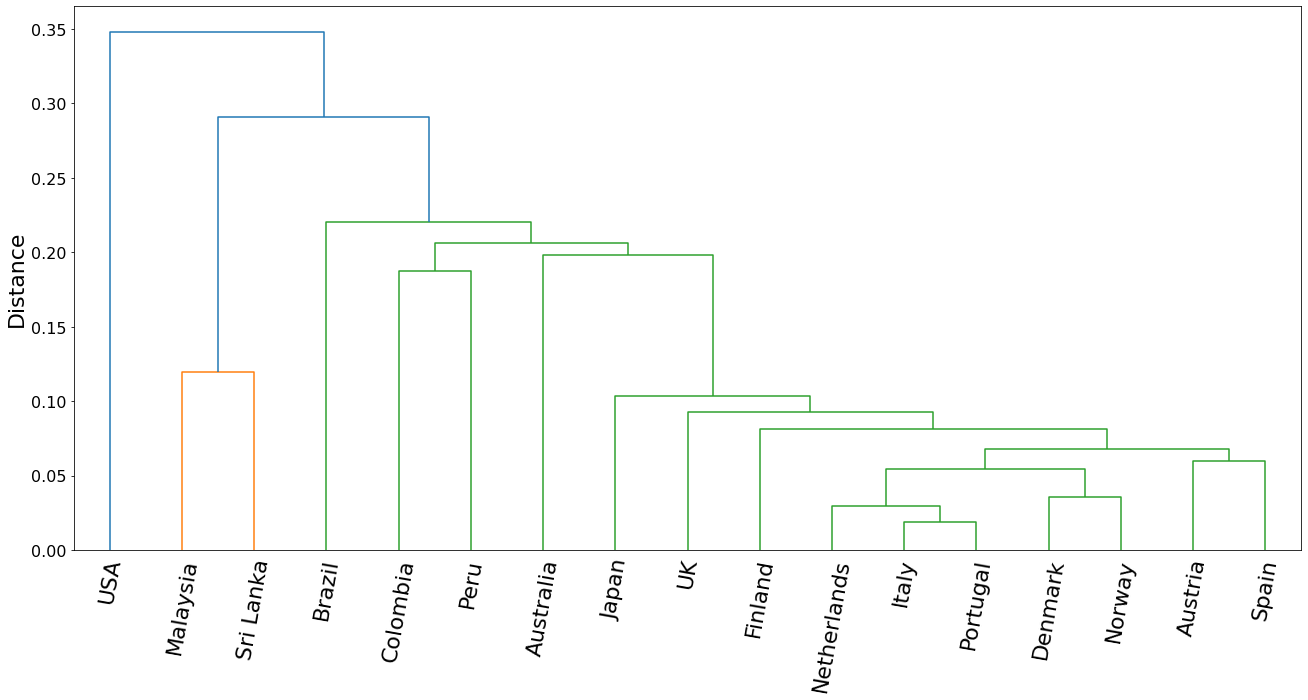

In [71]:
plot_dendrogram(22, 10, 'single', 'hamming')

#### Average Linkage


- The **Average Linkage** is quite similar to the Single Linkage.
- The difference is on how we define the distance between clusters.
- In the Single Linkage we used minimum, in the Average Linkage we use the average between all pairs of elements between clusters.
- Changes in the distance metrics may affect the Average linkage, even if it doesn't change the ordering.

In [72]:
dist2 = dist.copy()
new_cluster = dist2.loc[('Italy','Portugal'),:].mean(axis=0).drop(index=['Italy', 'Portugal'])
new_cluster = new_cluster.rename('(Italy, Portugal)')

dist2['(Italy, Portugal)'] = new_cluster
dist2 = dist2.append(new_cluster, ignore_index=False)
dist2.iloc[-1,-1]=600
dist2.loc[('Italy','Portugal', '(Italy, Portugal)'),:]

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA,"(Italy, Portugal)"
country,,,,,,,,,,,,,,,,,,
Italy,0.233696,0.116848,0.415761,0.407609,0.062500,0.127717,inf,0.111413,0.562500,0.029891,0.084239,0.271739,0.019022,0.081522,0.543478,0.108696,0.440217,NaN
Portugal,0.239130,0.111413,0.421196,0.407609,0.065217,0.116848,0.019022,0.103261,0.567935,0.035326,0.081522,0.271739,inf,0.067935,0.548913,0.108696,0.448370,NaN
"(Italy, Portugal)",0.236413,0.114130,0.418478,0.407609,0.063859,0.122283,NaN,0.107337,0.565217,0.032609,0.082880,0.271739,NaN,0.074728,0.546196,0.108696,0.444293,600.0


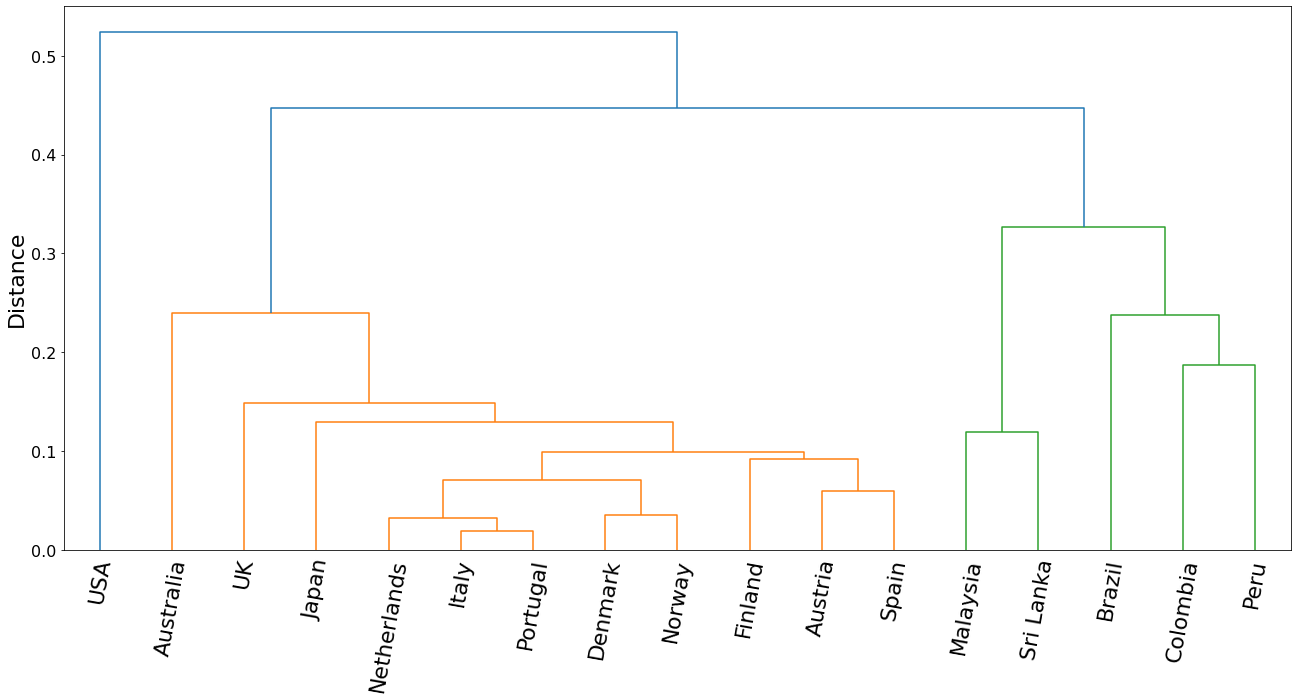

In [73]:
plot_dendrogram(22,10, 'average', 'hamming')

#### Complete Linkage

The Complete Linkage uses the maximum distance between all pair of elements (one element from each clusters); 

In [74]:
dist2 = dist.copy()
new_cluster = dist2.loc[('Italy','Portugal'),:].max(axis=0).drop(index=['Italy', 'Portugal'])
new_cluster = new_cluster.rename('(Italy, Portugal)')

dist2['(Italy, Portugal)'] = new_cluster
dist2 = dist2.append(new_cluster, ignore_index=False)
dist2.iloc[-1,-1]=600
dist2.loc[('Italy','Portugal', '(Italy, Portugal)'),:]

country,Australia,Austria,Brazil,Colombia,Denmark,Finland,Italy,Japan,Malaysia,Netherlands,Norway,Peru,Portugal,Spain,Sri Lanka,UK,USA,"(Italy, Portugal)"
country,,,,,,,,,,,,,,,,,,
Italy,0.233696,0.116848,0.415761,0.407609,0.062500,0.127717,inf,0.111413,0.562500,0.029891,0.084239,0.271739,0.019022,0.081522,0.543478,0.108696,0.440217,NaN
Portugal,0.239130,0.111413,0.421196,0.407609,0.065217,0.116848,0.019022,0.103261,0.567935,0.035326,0.081522,0.271739,inf,0.067935,0.548913,0.108696,0.448370,NaN
"(Italy, Portugal)",0.239130,0.116848,0.421196,0.407609,0.065217,0.127717,NaN,0.111413,0.567935,0.035326,0.084239,0.271739,NaN,0.081522,0.548913,0.108696,0.448370,600.0


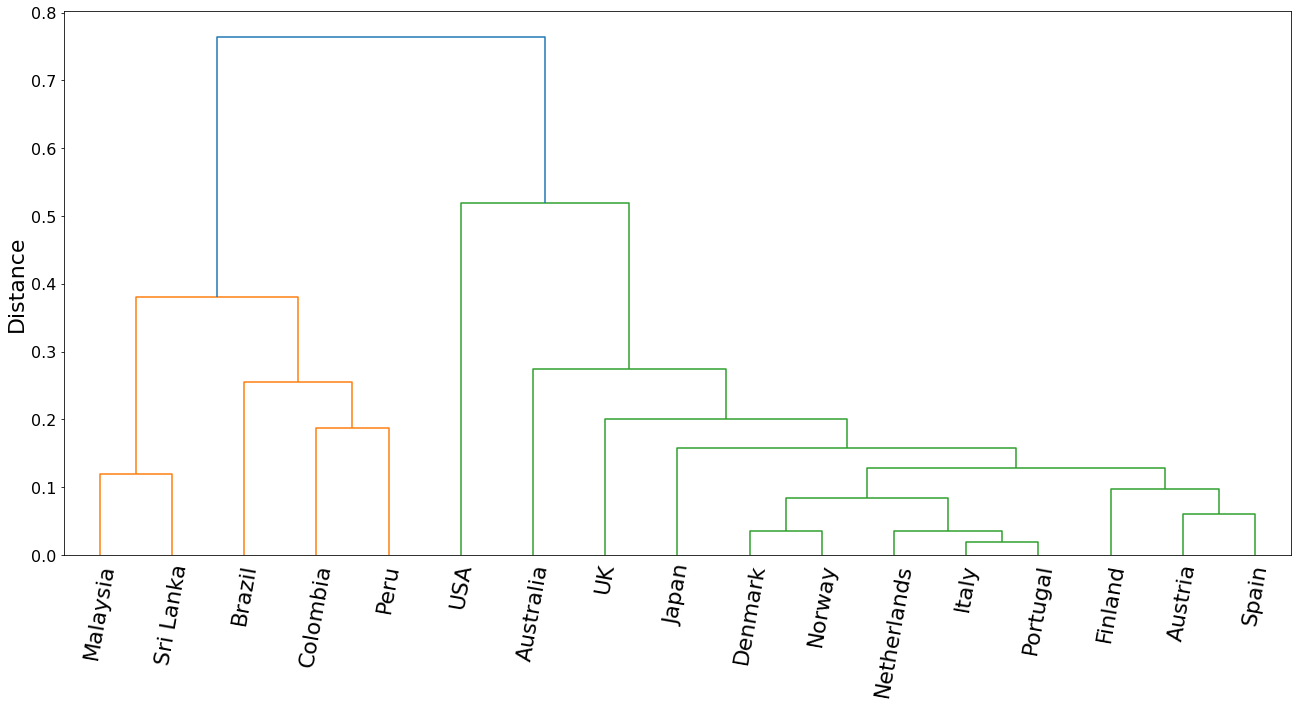

In [75]:
plot_dendrogram(22, 10, 'complete', 'hamming')

#### Ward's Hierarchical Clustering Method


- So far we have been merging clusters based on distance.
- Ward's Hierarchical Clustering Method merges clusters based on the inertia (intra-cluster distance).
- In this way, we merge the two clusters that will cause the minimum increase in the inertia.
- This method requires Euclidean Distance as well.

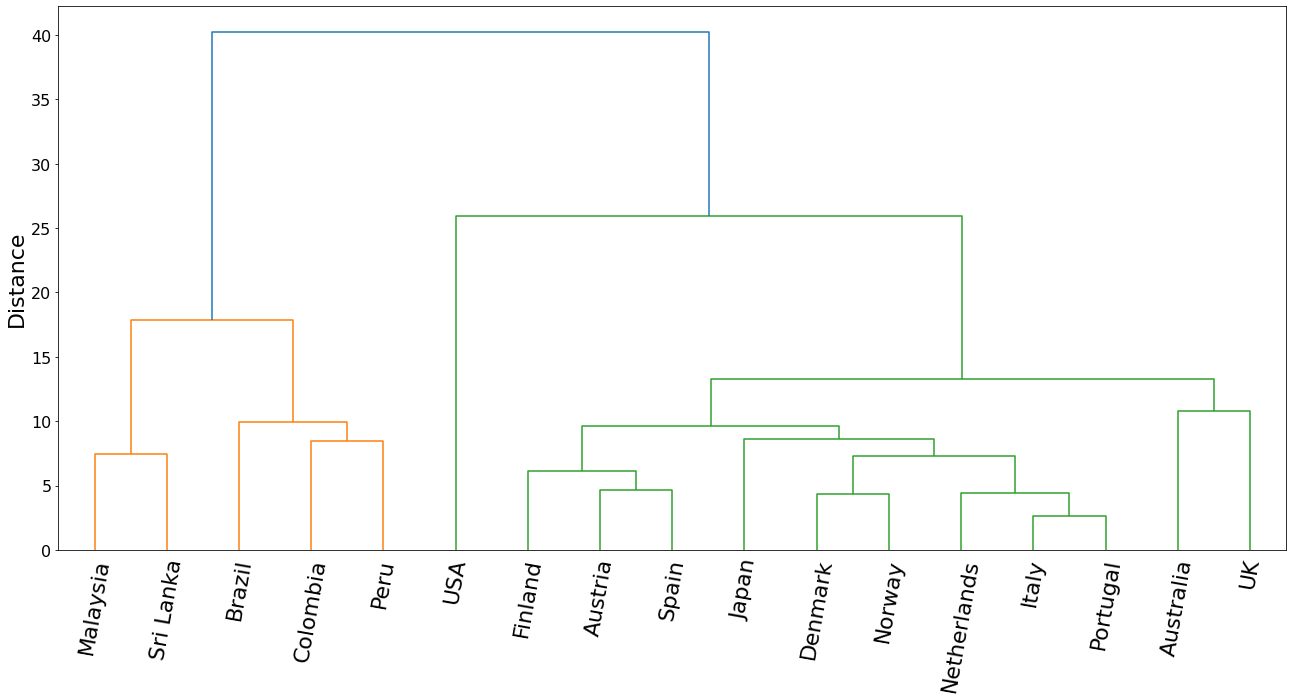

In [76]:
plot_dendrogram(22, 10, 'ward', 'euclidean')

#### Hierarchical Clustering in Python

- Unfortunately, `sklearn` does not support this.
- For hierarchical clustering, the package [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) is helpful.
- You might need these three functions from `scipy.cluster.hierarchy`: 
    - [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
    - [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram)
    - [fcluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster)

#### Understanding the output of `linkage`

- The function `linkage` will return a matrix (n-1)x4:
    - First and second columns: indexes of the clusters being merged.
    - Third column: the distance between the clusters being merged.
    - Fourth column: the number of elements in the newly formed cluster.
    
- The rows represent the iterations.

In [77]:
linkage(votes, metric='cityblock')

array([[  6.,  12.,   7.,   2.],
       [  9.,  17.,  13.,   3.],
       [  4.,  10.,  15.,   2.],
       [ 18.,  19.,  22.,   5.],
       [  1.,  13.,  22.,   2.],
       [ 20.,  21.,  26.,   7.],
       [  5.,  22.,  32.,   8.],
       [  7.,  23.,  41.,   9.],
       [ 15.,  24.,  47.,  10.],
       [  8.,  14.,  48.,   2.],
       [  3.,  11.,  70.,   2.],
       [  0.,  25.,  77.,  11.],
       [  2.,  27.,  81.,   3.],
       [ 28.,  29.,  87.,  14.],
       [ 26.,  30., 119.,  16.],
       [ 16.,  31., 189.,  17.]])

- If you want to truncate the tree in the dendrogram (specially when you have a big $n$) you can use
    - `dendrogram(output_linkage, desired_n_cluster, truncate_mode='lastp')` 
    

- Alternatively, you can truncate the tree down to $x$ levels from the single cluster:
    - `dendrogram(output_linkage, x, truncate_mode='level')` 

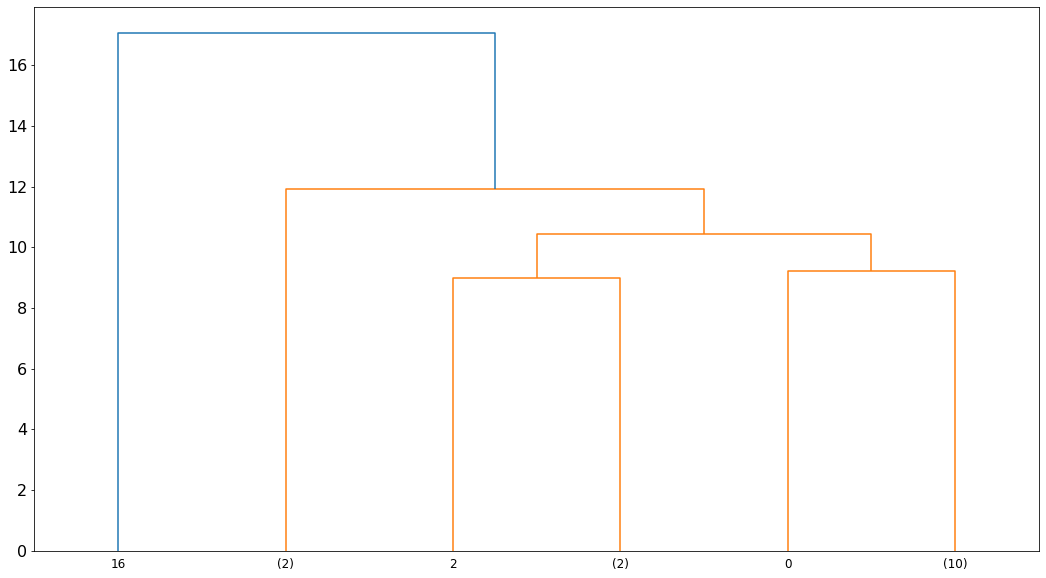

In [78]:
Z = linkage(votes)
fig, ax = plt.subplots(figsize=(18,10))
dendrogram(Z, 6, truncate_mode='lastp', ax=ax);

- The output matrix from the `linkage` function might be of little use other than for the dendrogram;
- To bring the clustering to a "flat" format, we can use
    - `fcluster(output_linkage, n_cluster, criterion='maxclust')`
<br>
<br>

In [79]:
fcluster(Z, 6, criterion='maxclust')

array([5, 4, 3, 2, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4, 1, 4, 6], dtype=int32)

All this is fairly similar to the nearest neighbours we talked about earlier, except we are extending it to clusters instead of just examples.

## True/False questions (15 min)

Let's see how this goes in a virtual environment.

1. A clustering of $n$ points with 10 clusters will always have a smaller total intra-cluster distance than a clustering with 5 clusters. 
2. With $k$-means clustering, we are sometimes interested in the cluster assignments of training points and sometimes in the cluster means. 
3. With DBSCAN, we are sometimes interested in the cluster assignments and sometimes in the cluster means. 
4. With $k$-means clustering, using too many clusters is analogous to overfitting.
5. With agglomerative hierarchical clustering (what we talked about), the first examples to be joined are close to the other examples.
